In [242]:

from scipy.optimize import curve_fit
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
from utils.plot_utils import combine_pdf_big
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

%matplotlib inline
%matplotlib inline


## Load data

In [243]:
# load basic ephys
target_folder = '/root/capsule/scratch/manuscript/F_basicephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', 'basic_ephys_low')
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [244]:
# load and add model variables

beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', 'beh_all')

model_combined = pd.read_csv(os.path.join(beh_folder, 'figures_in_generation', 'model_combined_beh_all.csv'), index_col=0)
model_combined['theta'] = model_combined['theta'] - 0.5
model_combined['unit_id'] = model_combined['unit_id'].apply(to_str_intlike)

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)
# combined-beh
# model_combined = model_combined.merge(combined_labeled_beh[['session', 'selected', 'diff_1']], on=['session'], how='left')
# model_combined = model_combined[model_combined['selected']]

# load response
response_tbl = pd.read_csv(f'/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
response_tbl['unit_id'] = response_tbl['unit'].apply(to_str_intlike)

In [245]:
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# antidromic data
version = 'PrL_S1'
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)


In [246]:
density = False
criteria_name = 'basic_ephys_all'
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
    
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints, density=density, plot_all=False)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)


Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8326 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8326 -> 5853 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5853 -> 5830 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 5830 -> 2952 units passed
Applying conditional bounds for y_loc
 - y_loc: 2952 -> 2393 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 400
Number of non-opto rows after filtering: 2393


In [247]:
features_combined = basic_ephys_df.merge(combined_tagged_units_filtered, on=['session', 'unit_id'], how='inner')
# merge with model variables


In [248]:

features_combined = features_combined.merge(model_combined, on=['session', 'unit_id'], how='left')
# merge with response
features_combined = features_combined.merge(response_tbl, on=['session', 'unit_id'], how='left')

In [249]:
# plot all autocorrelograms
filter = features_combined['be_filter'].values
auto_corr_bl = features_combined['acg_bl'].values
auto_corr = features_combined['acg'].values
auto_inhi_bin = 0.03
window_length = 3
auto_corr_mat_bl = np.array(auto_corr_bl.tolist())[filter][:, 1:]
auto_corr_mat = np.array(auto_corr.tolist())[filter][:, 1:]
units = features_combined['unit_id'].values[filter]
sessions = features_combined['session'].values[filter]

x_vals = np.array(range(int(window_length/auto_inhi_bin))) * auto_inhi_bin

In [250]:
fig = plt.figure(figsize=(5, 3))
plt.plot(x_vals, auto_corr_mat.T, color='k', alpha=0.5, linewidth=0.2);
plt.xlabel('Lag (s)')
# fig.savefig(os.path.join(target_folder, f'basic_ephys_all_autocorr_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Lag (s)')

In [251]:
# All acg denoise acf with PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- inputs ----
X = np.asarray(auto_corr_mat, float)   # shape (n_units, n_lags)
x = np.asarray(x_vals, float)          # shape (n_lags,)

n_components = 15
pca = PCA(n_components=n_components, svd_solver="full", random_state=0)

# Fit PCA on ACF matrix
scores = pca.fit_transform(X)          # (n_units, n_components)
explained_variance = pca.explained_variance_ratio_

# ---- Plot cumulative explained variance ----
plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, n_components + 1), np.cumsum(explained_variance), marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative Explained Variance")
plt.tight_layout()

# ---- Plot each PCA component (loading over lag) ----
n_cols = 3
n_rows = int(np.ceil(n_components / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2.3 * n_rows), sharex=True)
axes = np.atleast_2d(axes)

for i in range(n_components):
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(x, pca.components_[i], color="k")
    ax.set_title(f"PC{i+1} (EV={explained_variance[i]:.2%})")

# turn off unused axes
for j in range(n_components, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis("off")

plt.tight_layout()

# ---- Reconstruct using first k PCs ----
n_components_use = 10  # choose e.g. 9 (change as desired)
k = min(n_components_use, n_components)

# Reconstruction MUST add the mean back
auto_corr_mat_denoised = scores[:, :k] @ pca.components_[:k, :] + pca.mean_
auto_corr_mat_denoised = auto_corr_mat_denoised - np.mean(auto_corr_mat_denoised[:, -3:], axis=1, keepdims=True)  # re-zero at lag 0

# ---- Plot denoised ACF for 9 random examples ----
fig, axes = plt.subplots(5, 3, figsize=(20, 12), sharex=True, sharey=True)
samples = np.random.default_rng(0).choice(X.shape[0], size=15, replace=False)

for i, idx in enumerate(samples):
    ax = axes[i // 3, i % 3]
    ax.plot(x, X[idx], color="k", alpha=0.5, label="Original")
    ax.plot(x, auto_corr_mat_denoised[idx], color="r", lw=1.5, label=f"Denoised (k={k})")
    ax.set_title(f"Unit {idx}")

# show legend once
axes[0, 0].legend()
plt.tight_layout()
plt.show()


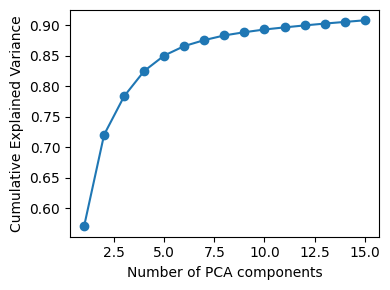

In [252]:
# baseline acg denoise acf with PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- inputs ----
X = np.asarray(auto_corr_mat_bl, float)   # shape (n_units, n_lags)
x = np.asarray(x_vals, float)          # shape (n_lags,)

n_components = 15
pca = PCA(n_components=n_components, svd_solver="full", random_state=0)

# Fit PCA on ACF matrix
scores = pca.fit_transform(X)          # (n_units, n_components)
explained_variance = pca.explained_variance_ratio_

# ---- Plot cumulative explained variance ----
plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, n_components + 1), np.cumsum(explained_variance), marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative Explained Variance")
plt.tight_layout()

# ---- Plot each PCA component (loading over lag) ----
n_cols = 3
n_rows = int(np.ceil(n_components / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2.3 * n_rows), sharex=True)
axes = np.atleast_2d(axes)

for i in range(n_components):
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(x, pca.components_[i], color="k")
    ax.set_title(f"PC{i+1} (EV={explained_variance[i]:.2%})")

# turn off unused axes
for j in range(n_components, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis("off")

plt.tight_layout()

# ---- Reconstruct using first k PCs ----
n_components_use = 10  # choose e.g. 9 (change as desired)
k = min(n_components_use, n_components)

# Reconstruction MUST add the mean back
auto_corr_mat_bl_denoised = scores[:, :k] @ pca.components_[:k, :] + pca.mean_
auto_corr_mat_bl_denoised = auto_corr_mat_bl_denoised - np.mean(auto_corr_mat_bl_denoised[:, -3:], axis=1, keepdims=True)  # re-zero at lag 0
# ---- Plot denoised ACF for 9 random examples ----
fig, axes = plt.subplots(5, 3, figsize=(20, 12), sharex=True, sharey=True)
samples = np.random.default_rng(0).choice(X.shape[0], size=15, replace=False)

for i, idx in enumerate(samples):
    ax = axes[i // 3, i % 3]
    ax.plot(x, X[idx], color="k", alpha=0.5, label="Original")
    ax.plot(x, auto_corr_mat_bl_denoised[idx], color="r", lw=1.5, label=f"Denoised (k={k})")
    ax.set_title(f"Unit {idx}")

# show legend once
axes[0, 0].legend()
plt.tight_layout()
plt.show()


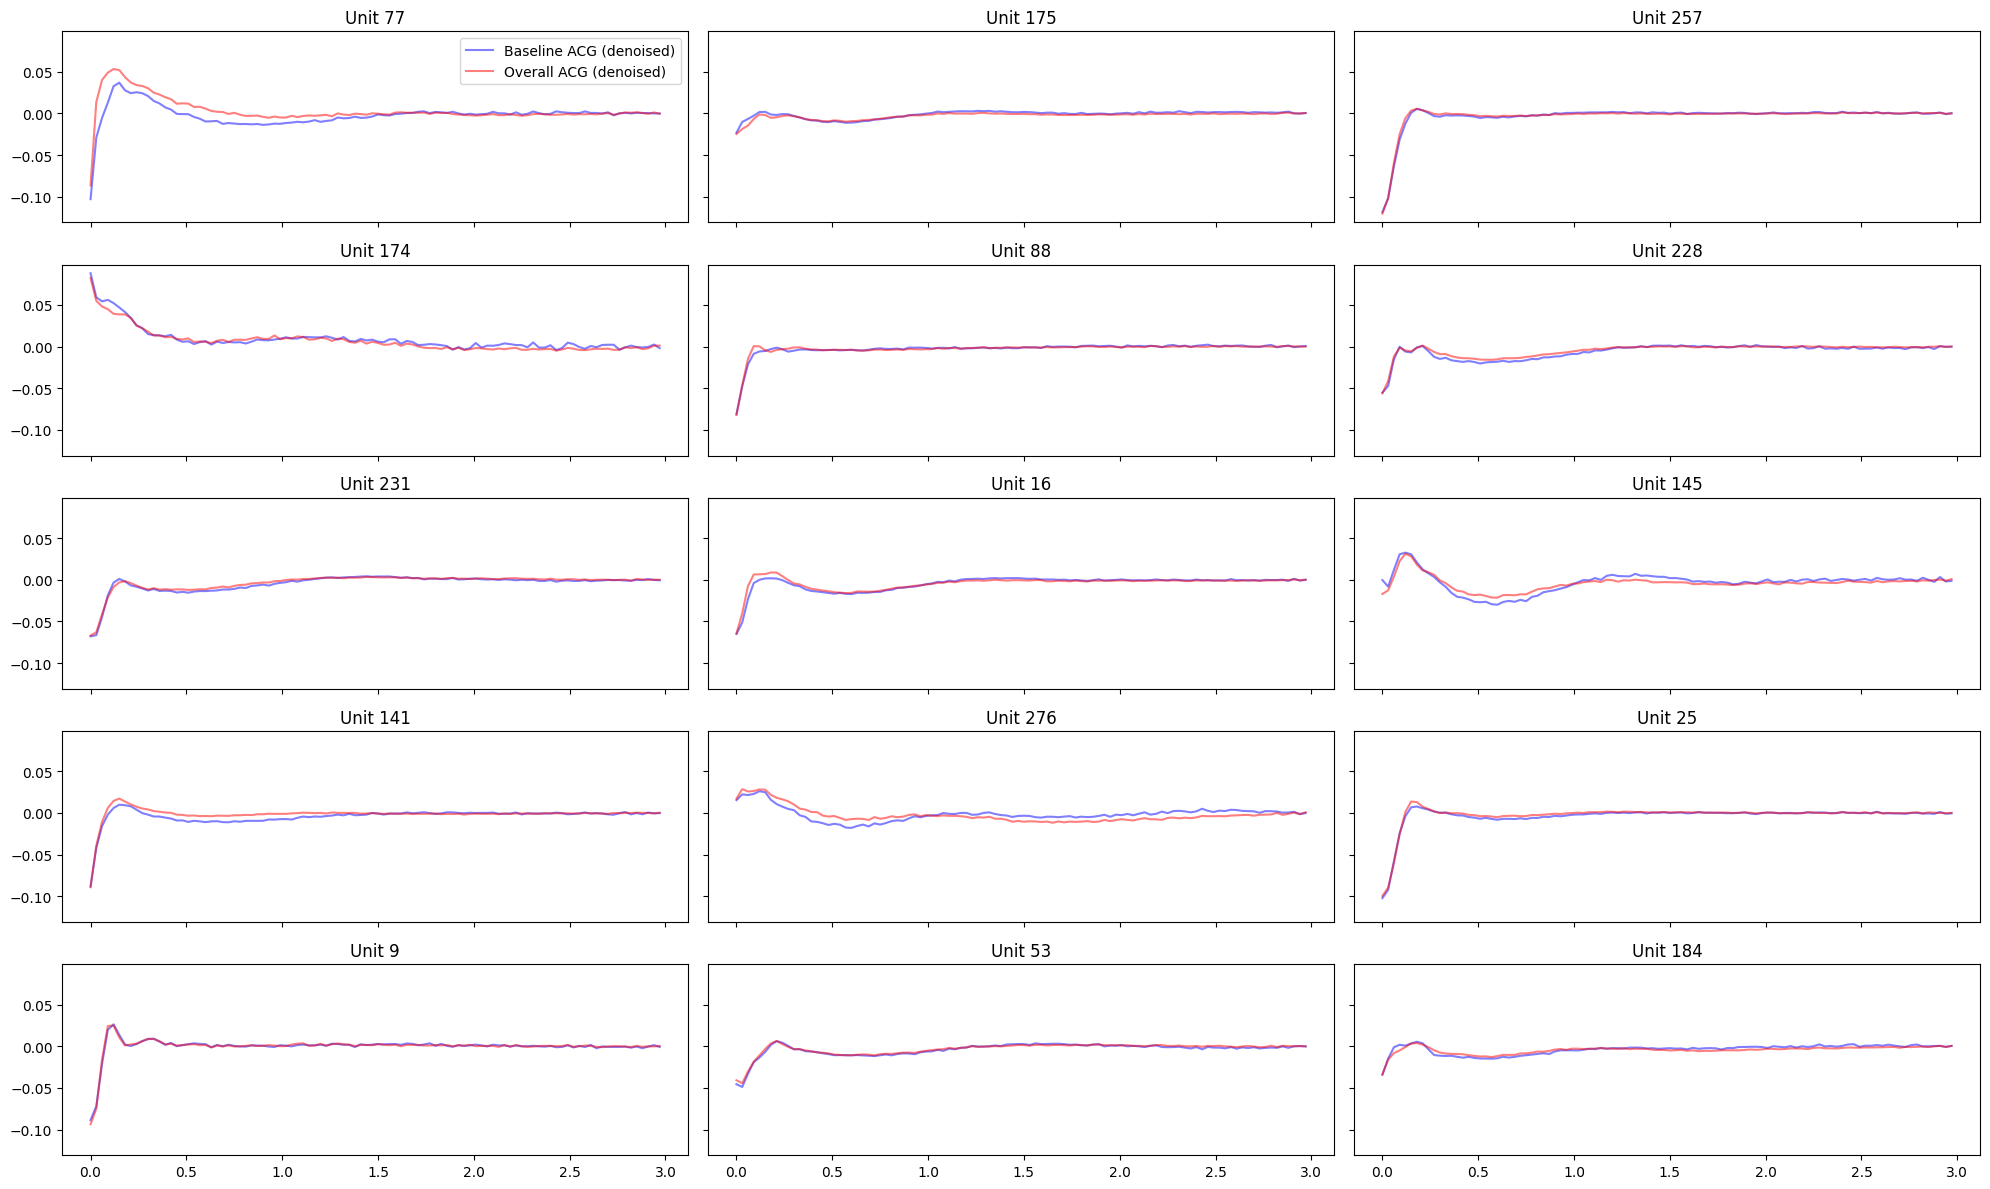

In [253]:
# Compare same neuron's baseline and overall acg after cleaning
fig, axes = plt.subplots(5, 3, figsize=(20, 12), sharex=True, sharey=True)
samples = np.random.default_rng(0).choice(X.shape[0], size=15, replace=False) + 5
for i, idx in enumerate(samples):
    ax = axes[i // 3, i % 3]
    ax.plot(x, auto_corr_mat_bl_denoised[idx], color="b", alpha=0.5, label="Baseline ACG (denoised)")
    ax.plot(x, auto_corr_mat_denoised[idx], color="r", alpha=0.5, label="Overall ACG (denoised)")
    ax.set_title(f"Unit {idx}")
# show legend once
axes[0, 0].legend()
plt.tight_layout()


In [254]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt

def fit_acf(acf, dt, ftol=1e-12, xtol=1e-12, gtol=1e-12, verbose=0, p0 = None):

    t = np.arange(len(acf)) * dt

    # ---------- Model ----------
    K2 = 6
    K3 = 4

    def gamma_peak(t, A, peak, k):
        tau = peak / (k - 1)
        x = np.maximum(t, 0) / tau
        return A * (x**(k - 1)) * np.exp(-x)

    def model(theta):

        A1, tau1, A2, peak2, A3, peak3 = theta

        tau2 = peak2 / (K2 - 1)
        tau3 = peak3 / (K3 - 1)

        C1 = -A1 * np.exp(-t / tau1)
        C2 =  gamma_peak(t, A2, peak2, K2)
        C3 = -gamma_peak(t, A3, peak3, K3)

        return C1 + C2 + C3

    # ---------- Residual ----------
    def residual(theta):
        return model(theta) - acf

    # ---------- Initial guesses ----------
    if p0 is None:
        p0 = np.array([
            np.abs(acf[0]),   # A1
            0.03,             # tau1
            max(np.max(acf[t<=0.25]-acf[-1]), 0),      # A2
            0.1,              # peak2
            -min(0, np.min(acf[t>=0.2])),  # A3
            0.7               # peak3
        ])
    print("Initial parameter guesses:", p0)
    # ---------- Bounds ----------
    lower = [0, dt, 0, dt, 0, 0.1]
    upper = [1, 0.2, 1, 0.5, 1, 1.2]

    # ---------- Least Squares ----------
    res = least_squares(
        residual,
        p0,
        bounds=(lower, upper),
        method="trf",
        x_scale="jac",   # ⭐ automatic scaling
        ftol=ftol,
        xtol=xtol,
        gtol=gtol,
        max_nfev=10000,
        verbose=verbose
    )

    theta = res.x

    # ---------- Plot ----------
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))

    axes[0].plot(t, acf, 'o', label="ACF")
    axes[0].plot(t, model(theta), label="Fit")
    axes[0].axhline(0, color='gray', lw=1, ls='--')
    axes[0].legend(loc="best")

    axes[1].plot(t, model(theta) - acf)
    axes[1].set_title("Residual")

    # plot first peak
    A1, tau1, A2, peak2, A3, peak3 = theta
    tau2 = peak2 / (K2 - 1)
    axes[2].plot(t, -A1 * np.exp(-t / tau1))
    axes[2].set_title(f"Short inhibition C1: tau={tau1:.3f}s, A={A1:.3f}")
    axes[3].plot(t, gamma_peak(t, A2, peak2, K2), label=f"C2: peak={peak2:.3f}s, A={A2:.3f}")
    axes[3].set_title("Mid excitation (C2)")
    axes[4].plot(t, -gamma_peak(t, A3, peak3, K3), label=f"C3: peak={peak3:.3f}s, A={A3:.3f}")
    axes[4].set_title("Long inhibition (C3)")
    
    plt.tight_layout()

    return theta, fig, axes


In [375]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt

def gamma_peak(t, A, peak, k):
    k = np.maximum(k, 1.01)
    tau = peak / (k - 1.0)
    tau = np.maximum(tau, 1e-9)
    x = np.maximum(t, 0.0) / tau
    return A * (x ** (k - 1.0)) * np.exp(-x)

def model(t, theta, K3):
    A1, tau1, A2, peak2, k2, A3, peak3 = theta
    C1 = -A1 * np.exp(-t / tau1)
    C2 =  gamma_peak(t, A2, peak2, k2)
    C3 = -gamma_peak(t, A3, peak3, K3)
    return C1 + C2 + C3

def fit_acf(acf, dt, ftol=1e-12, xtol=1e-12, gtol=1e-12, verbose=0, p0=None):
    """
    Additive model:
      y(t) = C1(t) + C2(t) + C3(t)

      C1: short inhibition (negative exponential)
          C1(t) = -A1 * exp(-t/tau1)

      C2: mid excitation (positive gamma bump) with FREE k2 in [3, 7]
          C2(t) = +A2 * ( (t/tau2)^(k2-1) * exp(-t/tau2) )
          parameterized by peak2 so tau2 = peak2/(k2-1)

      C3: long inhibition (negative gamma bump) with fixed k3
          C3(t) = -A3 * ( (t/tau3)^(k3-1) * exp(-t/tau3) )
          parameterized by peak3 so tau3 = peak3/(k3-1)
    """
    acf = np.asarray(acf, float)
    t = np.arange(len(acf)) * dt

    # ---------- Model ----------
    K3 = 4.0



    # ---------- Residual ----------
    def residual(theta, k3 = K3):
        return model(t, theta, k3) - acf

    # ---------- Initial guesses ----------
    if p0 is None:
        
        p0 = np.array([
            acf[0],                 # A1
            0.015,                                  # tau1
            float(max(np.max(acf[t <= 0.25] - acf[-1]), 0.0)),  # A2
            0.10,                                  # peak2
            6.0,                                   # k2
            float(max(-np.min(acf[t >= 0.2]), 0.0)),# A3
            0.70                                   # peak3
        ], dtype=float)

    print("Initial parameter guesses:", p0)

    # ---------- Bounds ----------
    # [A1, tau1, A2, peak2,  k2,  A3, peak3]
    lower = [-1.0, 0.01,   -1.0, dt,  2.0, 0.0, 0.4]
    upper = [1.0, 0.20, 1.0, 0.4, 8, 0.2, 1.20]

    # ---------- Least Squares ----------
    res = least_squares(
        residual,
        p0,
        bounds=(lower, upper),
        method="trf",
        x_scale="jac",   # automatic scaling
        ftol=ftol,
        xtol=xtol,
        gtol=gtol,
        max_nfev=10000,
        verbose=verbose
    )

    theta = res.x
    y_fit = model(t, theta, K3)

    # ---------- GOF ----------
    y = acf
    resid = y - y_fit
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y - np.mean(y))**2))

    r2 = np.nan if ss_tot == 0 else (1.0 - ss_res / ss_tot)
    n = int(len(y))
    p = int(len(theta))
    adj_r2 = np.nan if (ss_tot == 0 or n <= p + 1) else (1.0 - (1.0 - r2) * (n - 1) / (n - p - 1))
    rmse = float(np.sqrt(ss_res / n)) if n > 0 else np.nan

    # Gaussian-residual AIC/BIC (up to an additive constant)
    eps = 1e-300
    aic = n * np.log(ss_res / max(n, 1) + eps) + 2 * p
    bic = n * np.log(ss_res / max(n, 1) + eps) + p * np.log(max(n, 1))

    # ---------- Plot ----------
    fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

    axes[0].plot(t, acf, 'o', label="ACF")
    axes[0].plot(t, y_fit, label="Fit")
    axes[0].axhline(0, color='gray', lw=1, ls='--')
    axes[0].legend(loc="lower right")
    axes[0].set_title(f"Fit (R²={r2:.3f}, RMSE={rmse:.4g})")

    axes[1].plot(t, y_fit - acf)
    axes[1].axhline(0, color='gray', lw=1, ls='--')
    axes[1].set_title("Residual (fit - data)")

    A1, tau1, A2, peak2, k2, A3, peak3 = theta
    tau2 = peak2 / (max(k2 - 1.0, 1e-6))
    tau3 = peak3 / (K3 - 1.0)

    C1 = -A1 * np.exp(-t / tau1)
    C2 =  gamma_peak(t, A2, peak2, k2)
    C3 = -gamma_peak(t, A3, peak3, K3)

    axes[2].plot(t, C1)
    axes[2].axhline(0, color='gray', lw=1, ls='--')
    axes[2].set_title(f"Short inhibition C1: tau1={tau1:.3f}s, A1={A1:.3f}")

    axes[3].plot(t, C2)
    axes[3].axhline(0, color='gray', lw=1, ls='--')
    axes[3].set_title(f"Mid excitation C2: peak2={peak2:.3f}s, tau2≈{tau2:.3f}s, k2={k2:.2f}, A2={A2:.3f}")

    axes[4].plot(t, C3)
    axes[4].axhline(0, color='gray', lw=1, ls='--')
    axes[4].set_title(f"Long inhibition C3: peak3={peak3:.3f}s, tau3≈{tau3:.3f}s, k3={K3:g}, A3={A3:.3f}")

    plt.tight_layout()

    outcome = {
        # parameters
        "A1": float(A1), "tau1": float(tau1),
        "A2": float(A2), "peak2": float(peak2), "k2": float(k2), "tau2": float(tau2),
        "A3": float(A3), "peak3": float(peak3), "k3": float(K3), "tau3": float(tau3),
        "P1": C1[0], 
        "P2": np.max(C2) if A2 > 0 else np.min(C2),
        "P3": np.min(C3) if A3 > 0 else np.max(C3),

        # fit diagnostics
        "success": bool(res.success),
        "status": int(res.status),
        "message": str(res.message),
        "nfev": int(res.nfev),
        "cost": float(res.cost),

        # GOF
        "ss_res": ss_res,
        "ss_tot": ss_tot,
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "adj_r2": float(adj_r2) if np.isfinite(adj_r2) else np.nan,
        "rmse": rmse,
        "aic": float(aic),
        "bic": float(bic),
    }

    return outcome, fig, axes


Initial parameter guesses: [-3.84584951e-02  1.50000000e-02  1.08136260e-02  1.00000000e-01
  6.00000000e+00  5.76127754e-03  7.00000000e-01]
`xtol` termination condition is satisfied.
Function evaluations 133, initial cost 7.4222e-02, final cost 2.4953e-05, first-order optimality 1.82e-11.


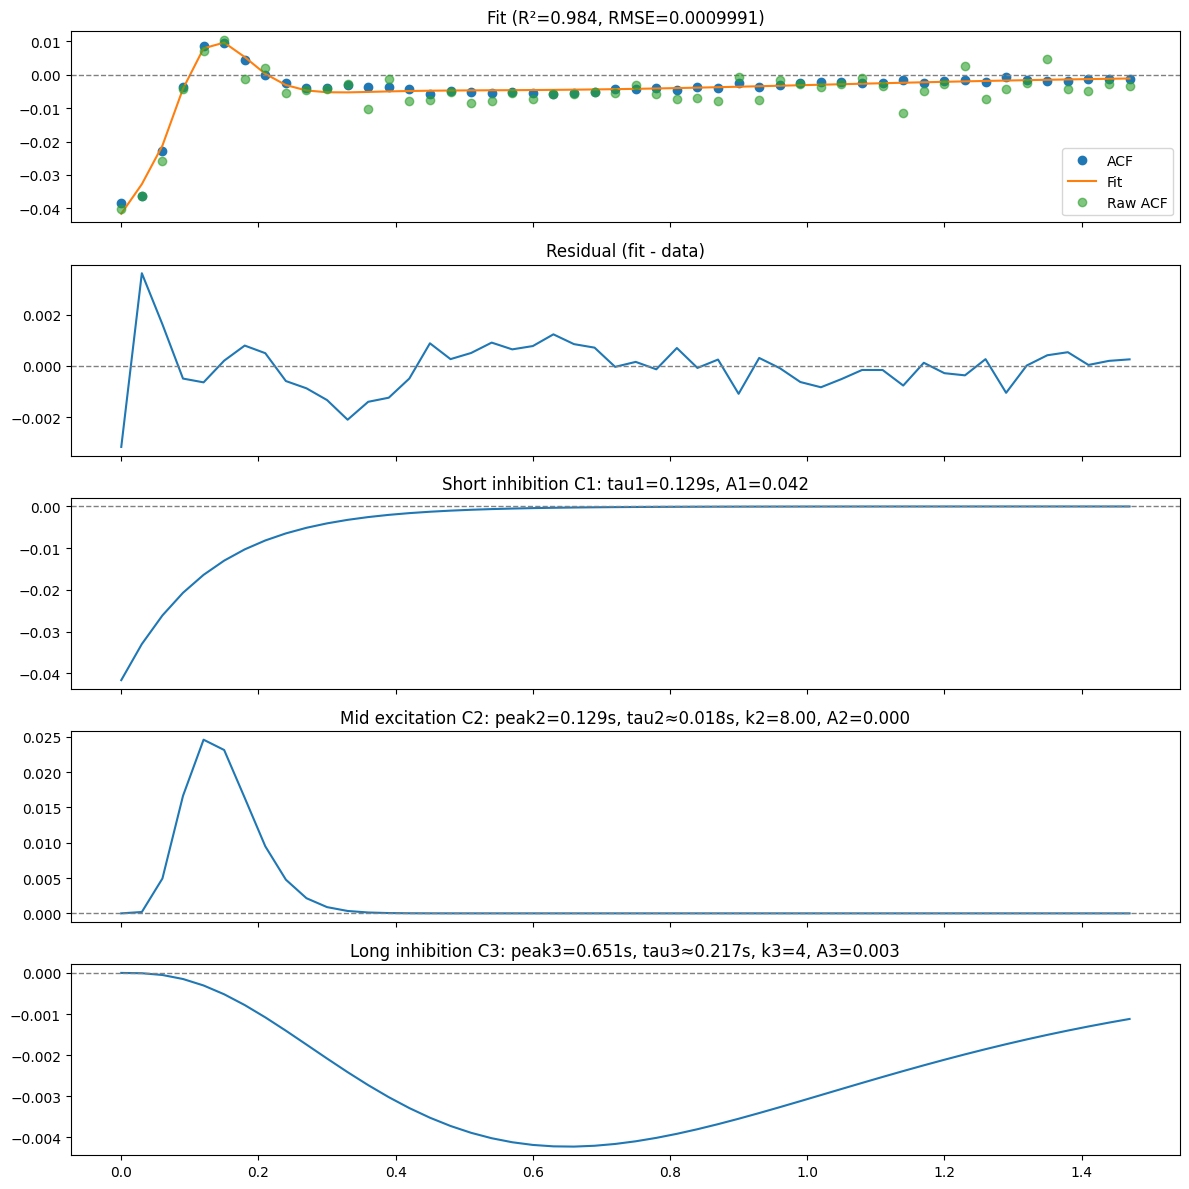

In [376]:
dt = 0.03
fit_sample = (0, int(np.round(1.5/dt)))
unit_ind = 123
acf = auto_corr_mat_denoised[unit_ind][fit_sample[0]:fit_sample[1]]
p0 = np.array([
    np.abs(acf[0]),   # A1
    0.03,             # tau1
    np.max(acf[x[fit_sample[0]:fit_sample[1]]<=0.25]),      # A2
    0.1,              # peak2
    -min(0, np.min(acf[x[fit_sample[0]:fit_sample[1]]>=0.2])),  # A3
    0.7               # peak3
])
params, fig, axes = fit_acf(
    acf,
    dt,
    ftol=10**-17,
    xtol=10**-50,
    verbose=1,
    p0=None
)

axes[0].plot(
    x[fit_sample[0]:fit_sample[1]],
    auto_corr_mat[unit_ind][fit_sample[0]:fit_sample[1]],
    'o', alpha=0.6, label="Raw ACF"
)

axes[0].legend()
plt.show()


In [377]:
# loop through all neurons
target_folder = '/root/capsule/scratch/manuscript/F_autocorr'
fit_folder = os.path.join(target_folder, 'acf_fits')
if not os.path.exists(fit_folder):
    os.makedirs(fit_folder)
dt = 0.03
fit_sample = (0, int(np.round(1.5/dt)))
all_params = []
for unit_ind, (unit_id, session_id) in enumerate(zip(units, sessions)):
    print(f"Fitting unit {unit_id} from session {session_id} (index {unit_ind})...")
    params, fig, axes = fit_acf(
        auto_corr_mat_denoised[unit_ind][fit_sample[0]:fit_sample[1]],
        dt,
        ftol=10**-17,
        xtol=10**-50,
        verbose=1
    )
    axes[0].plot(x[fit_sample[0]:fit_sample[1]], auto_corr_mat[unit_ind][fit_sample[0]:fit_sample[1]], 'o', alpha=0.6, label="Raw ACF")
    plt.suptitle(f"Unit {unit_id} from session {session_id}")
    fig.savefig(fname=os.path.join(fit_folder, f'session_{session_id} unit_{unit_id}_acf_fit.pdf'), dpi=300, bbox_inches='tight')
    plt.close('all')
    all_params.append(params)

Fitting unit 87 from session behavior_716325_2024-05-31_10-31-14 (index 0)...
Initial parameter guesses: [-8.08691848e-02  1.50000000e-02  6.25227475e-02  1.00000000e-01
  6.00000000e+00  4.82315769e-03  7.00000000e-01]
`xtol` termination condition is satisfied.
Function evaluations 119, initial cost 2.0414e+00, final cost 1.3741e-04, first-order optimality 4.81e-12.
Fitting unit 377 from session behavior_716325_2024-05-31_10-31-14 (index 1)...
Initial parameter guesses: [-0.15345721  0.015       0.03453279  0.1         6.          0.0070011
  0.7       ]
The maximum number of function evaluations is exceeded.
Function evaluations 10000, initial cost 7.8558e-01, final cost 6.9063e-05, first-order optimality 2.01e-06.
Fitting unit 379 from session behavior_716325_2024-05-31_10-31-14 (index 2)...
Initial parameter guesses: [-0.06365992  0.015       0.01353576  0.1         6.          0.00750007
  0.7       ]
`xtol` termination condition is satisfied.
Function evaluations 248, initial cos

In [258]:
# # combine single pdfs into a big one
# combine_pdf_big(fit_folder, os.path.join(target_folder, 'combined_fitting.pdf'))

In [378]:
all_params_df = pd.DataFrame(all_params)
all_params_df['unit_id'] = units
all_params_df['session'] = sessions
all_params_df.to_csv(os.path.join(target_folder, 'acf_fit_parameters.csv'), index=False)

In [379]:
# for each set of parameters, generate C1 C2 C3 and put in one matrix
K3 = 4.0
dt = 0.03
fit_sample = (0, int(np.round(1.5/dt)))
t = np.arange(fit_sample[1] - fit_sample[0]) * dt
t = np.arange(1, np.shape(auto_corr_mat_denoised)[1]+1) * dt
C1_mat = []
C2_mat = []
C3_mat = []
for idx, row in all_params_df.iterrows():
    A1 = row['A1']
    tau1 = row['tau1']
    A2 = row['A2']
    peak2 = row['peak2']
    k2 = row['k2']
    A3 = row['A3']
    peak3 = row['peak3']

    tau2 = peak2 / max(k2 - 1.0, 1e-6)
    tau3 = peak3 / (K3 - 1.0)

    C1 = -A1 * np.exp(-t / tau1)
    C2 =  gamma_peak(t, A2, peak2, k2)
    C3 = -gamma_peak(t, A3, peak3, K3)

    C1_mat.append(C1)
    C2_mat.append(C2)
    C3_mat.append(C3)

C1_mat = np.array(C1_mat)
C2_mat = np.array(C2_mat)
C3_mat = np.array(C3_mat)

In [370]:
all_params_df['P2']

0      0.064429
1      0.073152
2      0.039886
3      0.023952
4      0.038037
         ...   
275    0.037145
276    0.022627
277    0.111947
278   -0.003585
279    0.006687
Name: P2, Length: 280, dtype: float64

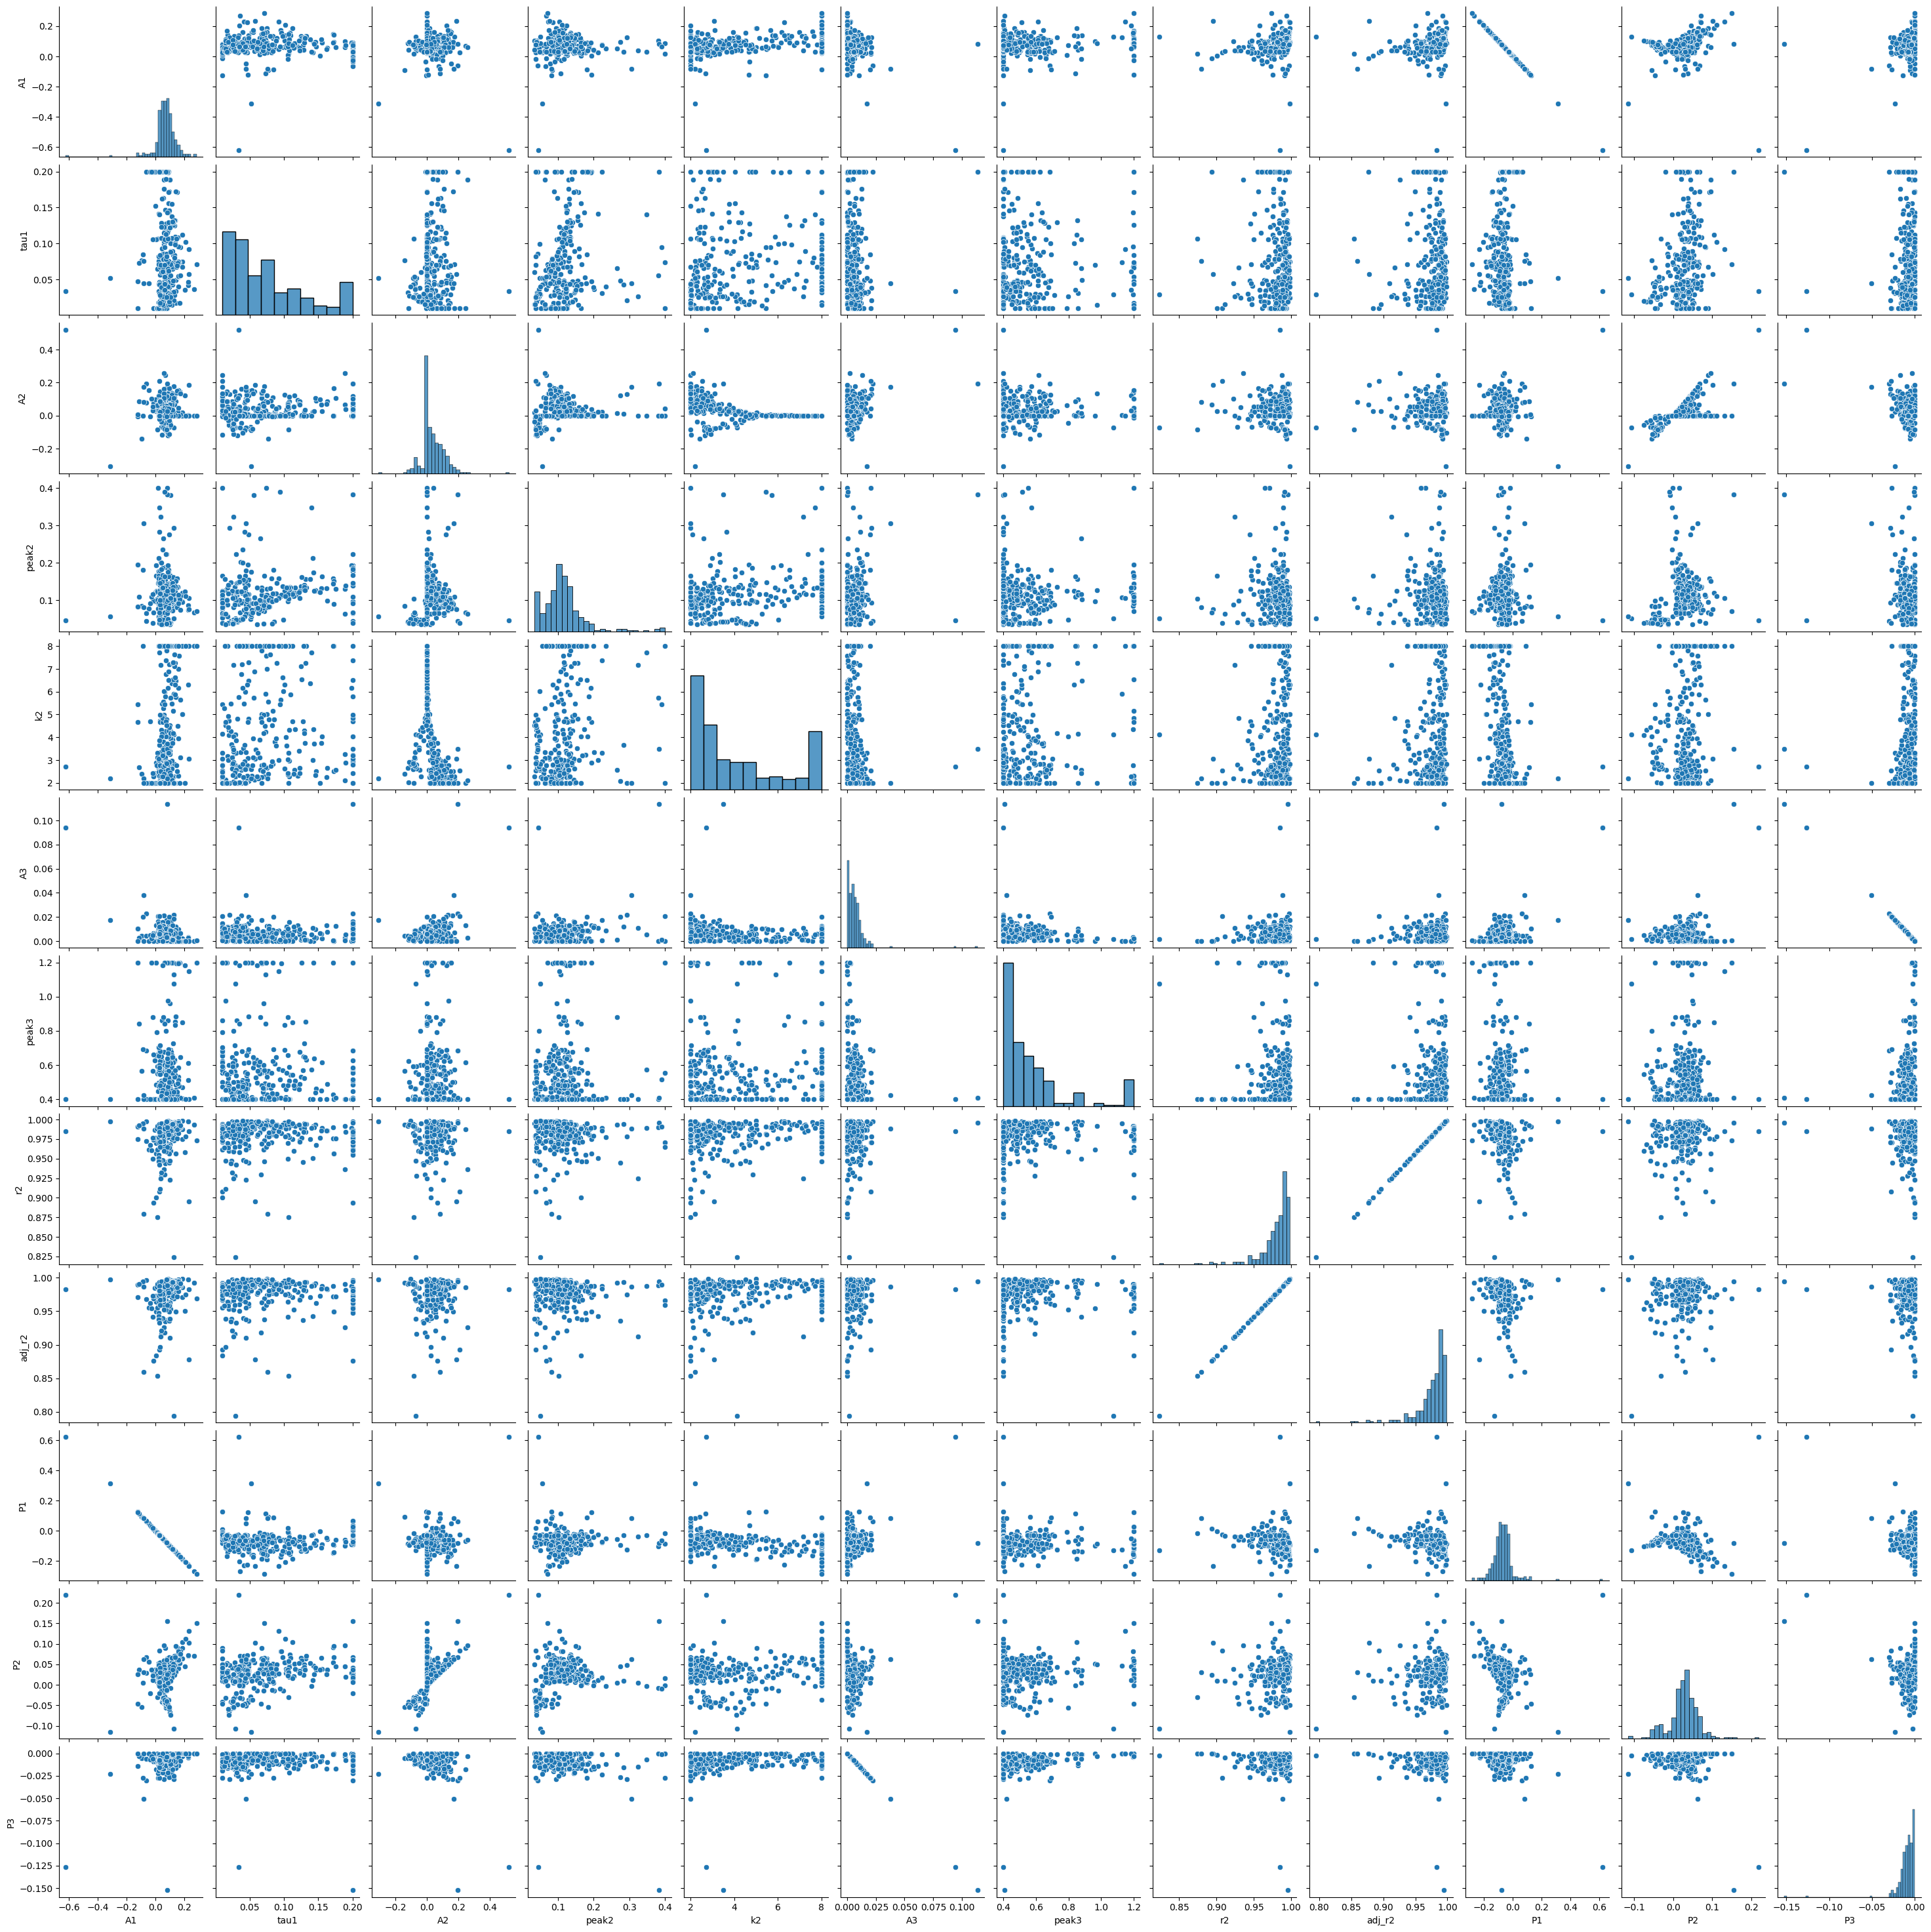

In [380]:
import seaborn as sns
sns.pairplot(all_params_df[['A1', 'tau1', 'A2', 'peak2', 'k2', 'A3', 'peak3', 'r2', 'adj_r2', 'P1', 'P2', 'P3']])

In [262]:
filter = (all_params_df['r2'] <0.9)
all_params_df[filter][['session', 'unit_id', 'r2']]

session    unit_id        r2
26   behavior_758017_2025-02-04_11-57-38        195  0.823775
106  behavior_782394_2025-04-24_12-07-34        437  0.895508
147   behavior_ZS059_2021-04-23_14-57-50  TT3_SS_01  0.874822
151   behavior_ZS061_2021-03-20_18-03-26  TT3_SS_01  0.893999
171   behavior_ZS061_2021-03-26_17-28-33  TT3_SS_01  0.879522

In [263]:
np.shape(C1_mat)

(280, 100)

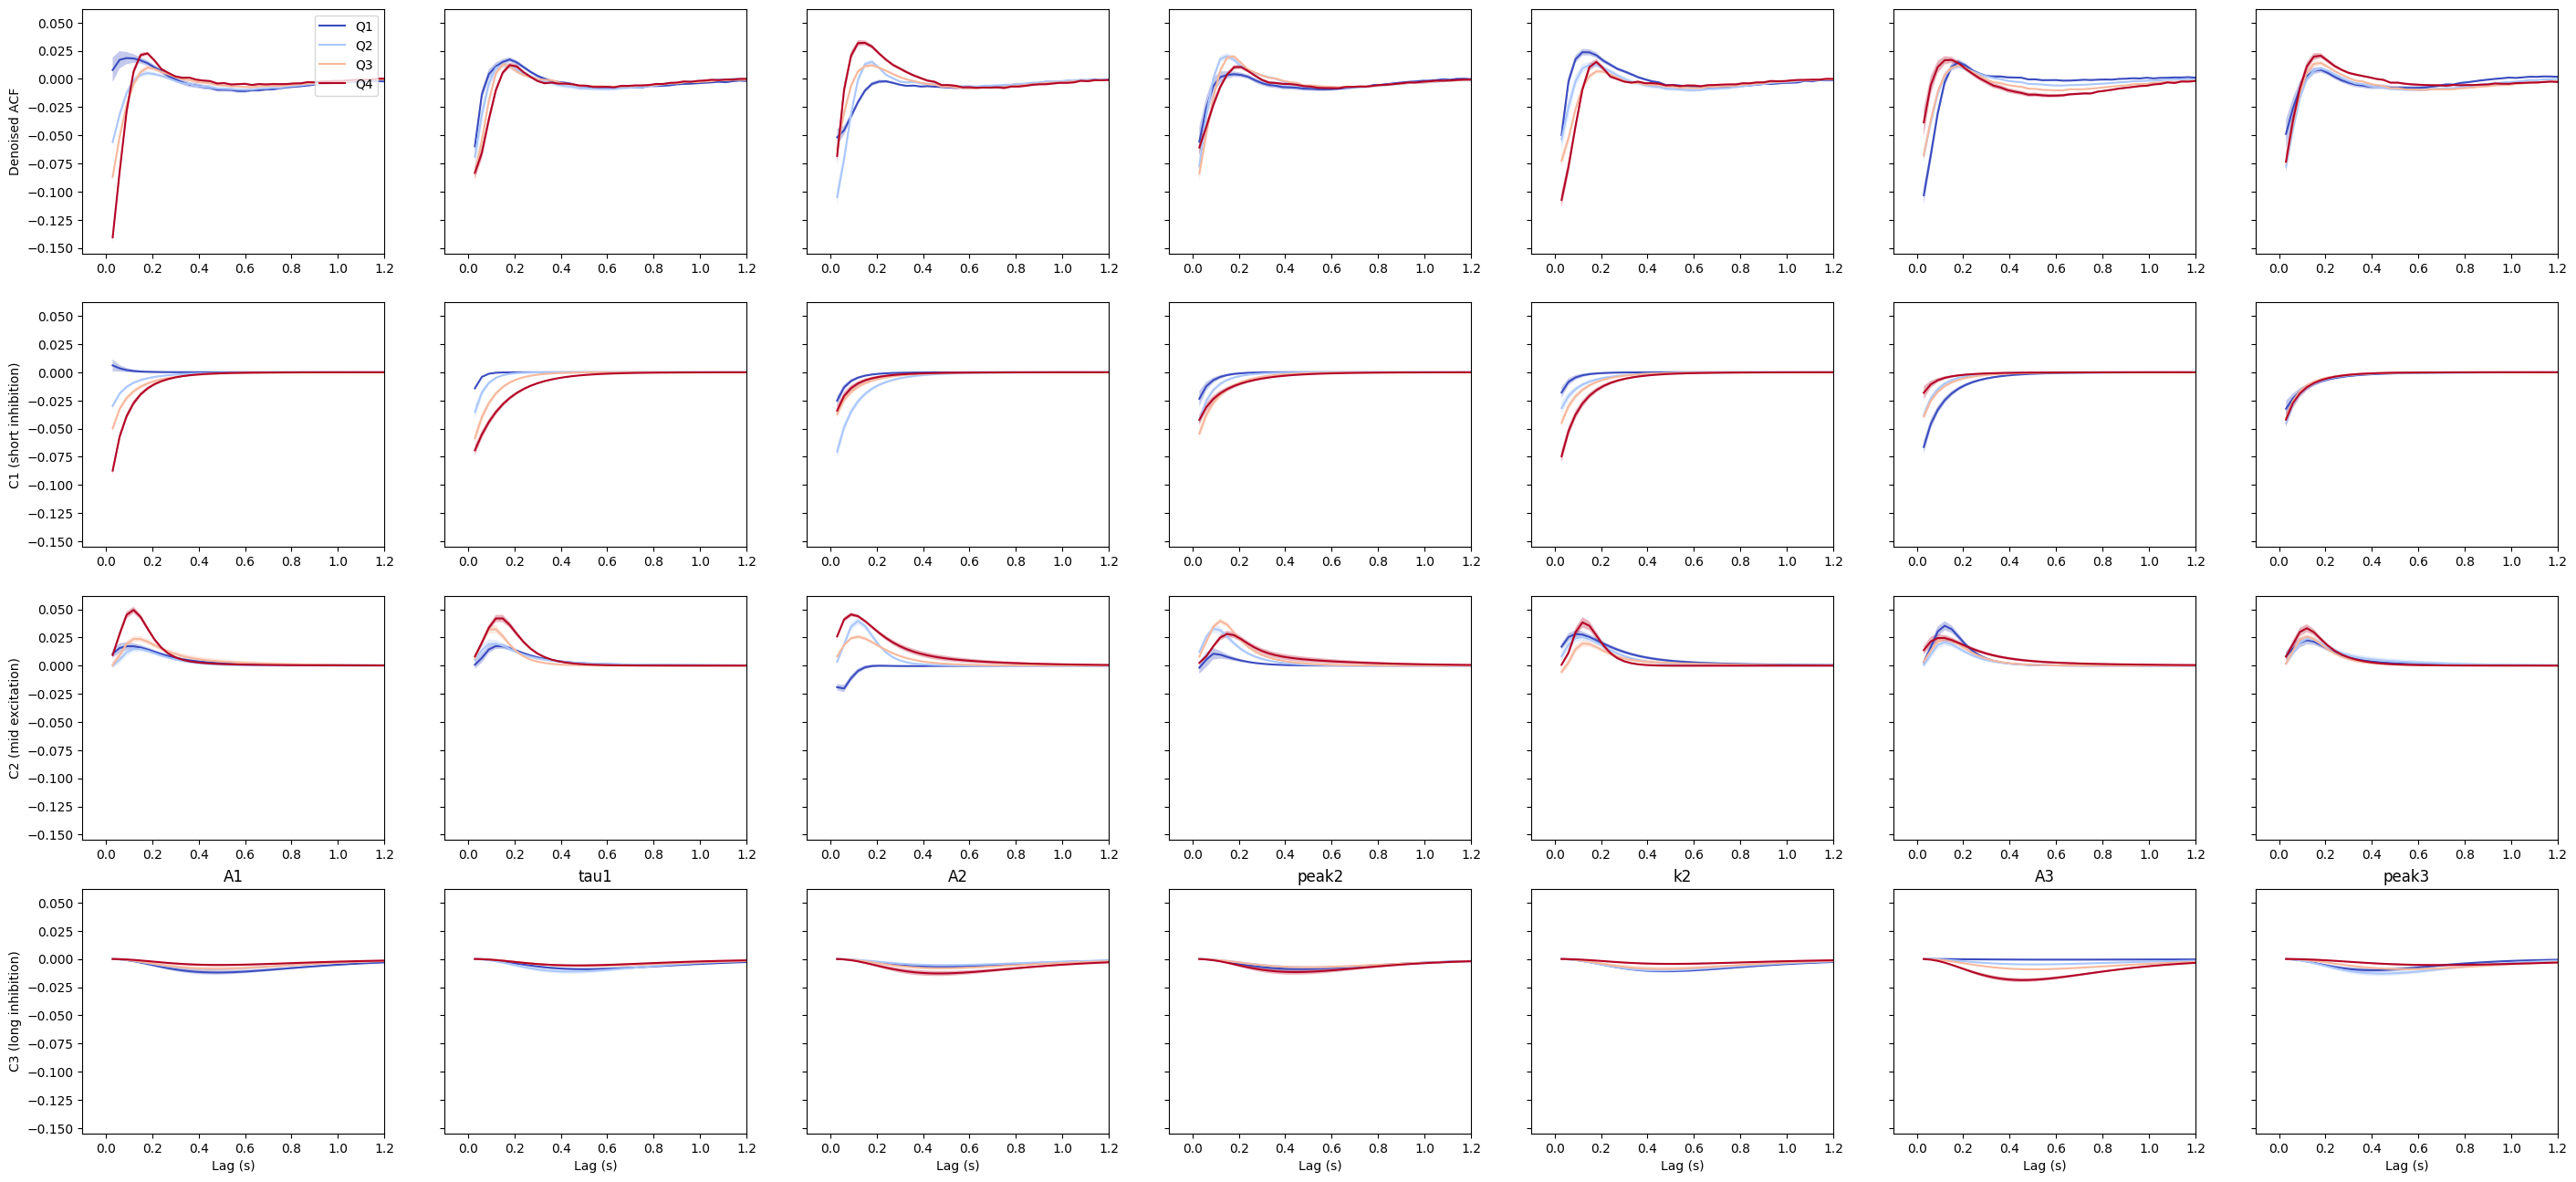

In [264]:
# mean acg, C1, C2 and C3 by each parameter quartiles
features_to_plot = ['A1', 'tau1', 'A2', 'peak2', 'k2', 'A3', 'peak3']
fig, axes = plt.subplots(4, len(features_to_plot), figsize=(5 * len(features_to_plot), 4*4), sharey=True)
bin_num = 4
cmap = cm.get_cmap("coolwarm", bin_num)
x_vals = np.arange(1, auto_corr_mat_denoised.shape[1]+1) * dt
for i, feature in enumerate(features_to_plot):
    curr_quantile = np.quantile(all_params_df[feature], q=np.linspace(0, 1, bin_num + 1))

    for q in range(4):
        filter = (all_params_df[feature] >= curr_quantile[q]) & (all_params_df[feature] < curr_quantile[q+1])
        # whole trace
        mean_acf = np.mean(auto_corr_mat_denoised[filter], axis=0)
        sem_acf = np.std(auto_corr_mat_denoised[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[0, i]
        ax.plot(x_vals, mean_acf, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_acf - sem_acf, mean_acf + sem_acf, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.legend(loc='upper right')
            ax.set_ylabel('Denoised ACF')
        # C1
        mean_C1 = np.mean(C1_mat[filter], axis=0)
        sem_C1 = np.std(C1_mat[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[1, i]
        ax.plot(x_vals, mean_C1, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_C1 - sem_C1, mean_C1 + sem_C1, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.set_ylabel('C1 (short inhibition)')
        # C2
        mean_C2 = np.mean(C2_mat[filter], axis=0)
        sem_C2 = np.std(C2_mat[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[2, i]
        ax.plot(x_vals, mean_C2, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_C2 - sem_C2, mean_C2 + sem_C2, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.set_ylabel('C2 (mid excitation)')
        # C3
        mean_C3 = np.mean(C3_mat[filter], axis=0)
        sem_C3 = np.std(C3_mat[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[3, i]
        ax.plot(x_vals, mean_C3, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_C3 - sem_C3, mean_C3 + sem_C3, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.set_ylabel('C3 (long inhibition)')


    ax.set_title(feature)

    ax.set_xlabel('Lag (s)')

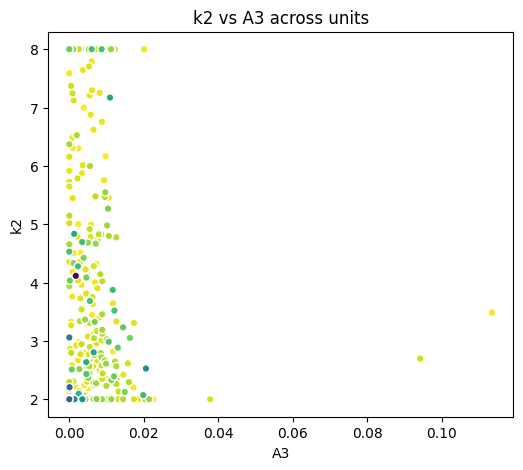

In [265]:
x_val = 'A3'
y_val = 'k2'
color_code = 'adj_r2'
fig = plt.figure(figsize=(6, 5))
sort_ind = np.argsort(all_params_df[color_code])[::-1]
plt.scatter(all_params_df[x_val][sort_ind], all_params_df[y_val][sort_ind], c = all_params_df[color_code][sort_ind], alpha=1, s = 30, edgecolors='white')
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.title(f"{y_val} vs {x_val} across units")
plt.show()


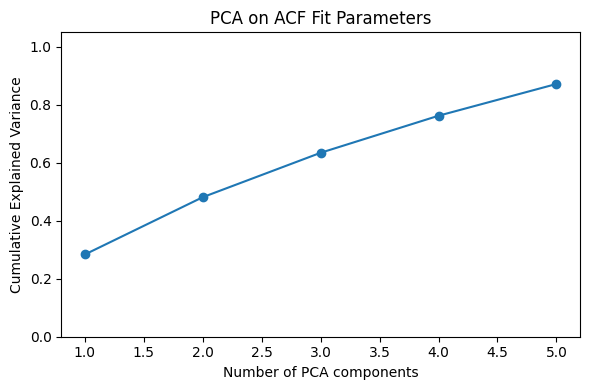

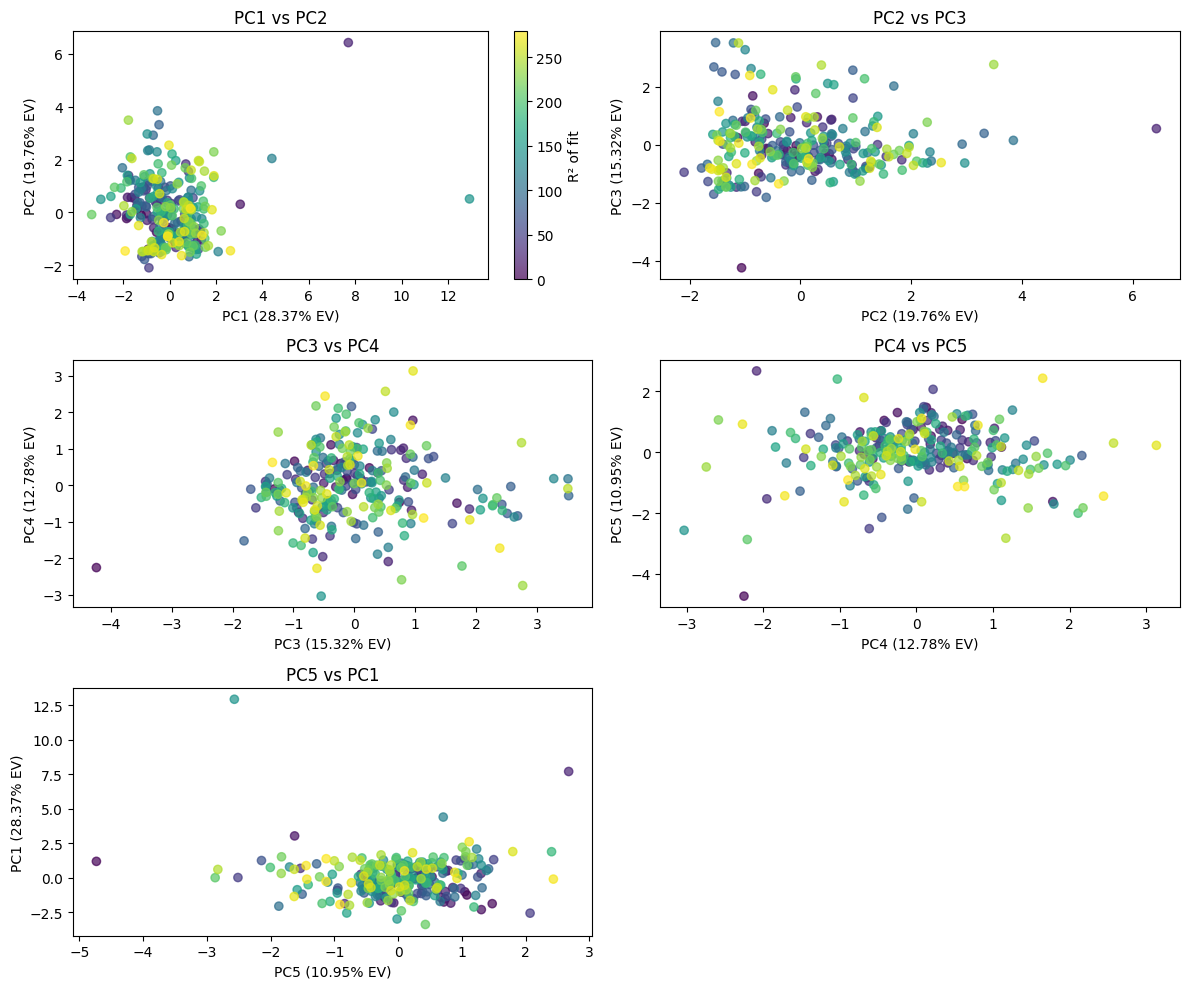

In [266]:
# pca on parameters
from sklearn.decomposition import PCA
param_cols = ['A1', 'tau1', 'A2', 'peak2', 'k2', 'A3', 'peak3']
pca = PCA(n_components=5)
param_data = all_params_df[param_cols].values
# standardize parameters before PCA
param_data = (param_data - np.mean(param_data, axis=0)) / np.std(param_data, axis=0)
pca_scores = pca.fit_transform(param_data)
explained_variance = pca.explained_variance_ratio_
# Plot PCA results
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')
plt.ylim(0, 1.05)
plt.title('PCA on ACF Fit Parameters')
plt.tight_layout()
plt.figure(figsize=(12, 10))
# colorcode by r2
color_code = all_params_df['adj_r2'].values
sort_ind = np.argsort(color_code)[::-1]
for i in range(5):
    plt.subplot(3, 2, i + 1)
    sg = plt.scatter(pca_scores[:, i][sort_ind], pca_scores[:, (i + 1) % 5][sort_ind], alpha=0.7, c = range(len(color_code)), cmap='viridis')
    plt.xlabel(f'PC{i+1} ({explained_variance[i]:.2%} EV)')
    plt.ylabel(f'PC{((i + 1) % 5) + 1} ({explained_variance[(i + 1) % 5]:.2%} EV)')
    plt.title(f'PC{i+1} vs PC{((i + 1) % 5) + 1}')
    if i == 0:
        plt.colorbar(sg, label='R² of fit')

plt.tight_layout()




In [267]:
# append pcs to parameters dataframe
for i in range(pca_scores.shape[1]):
    all_params_df[f'PC{i+1}'] = pca_scores[:, i]

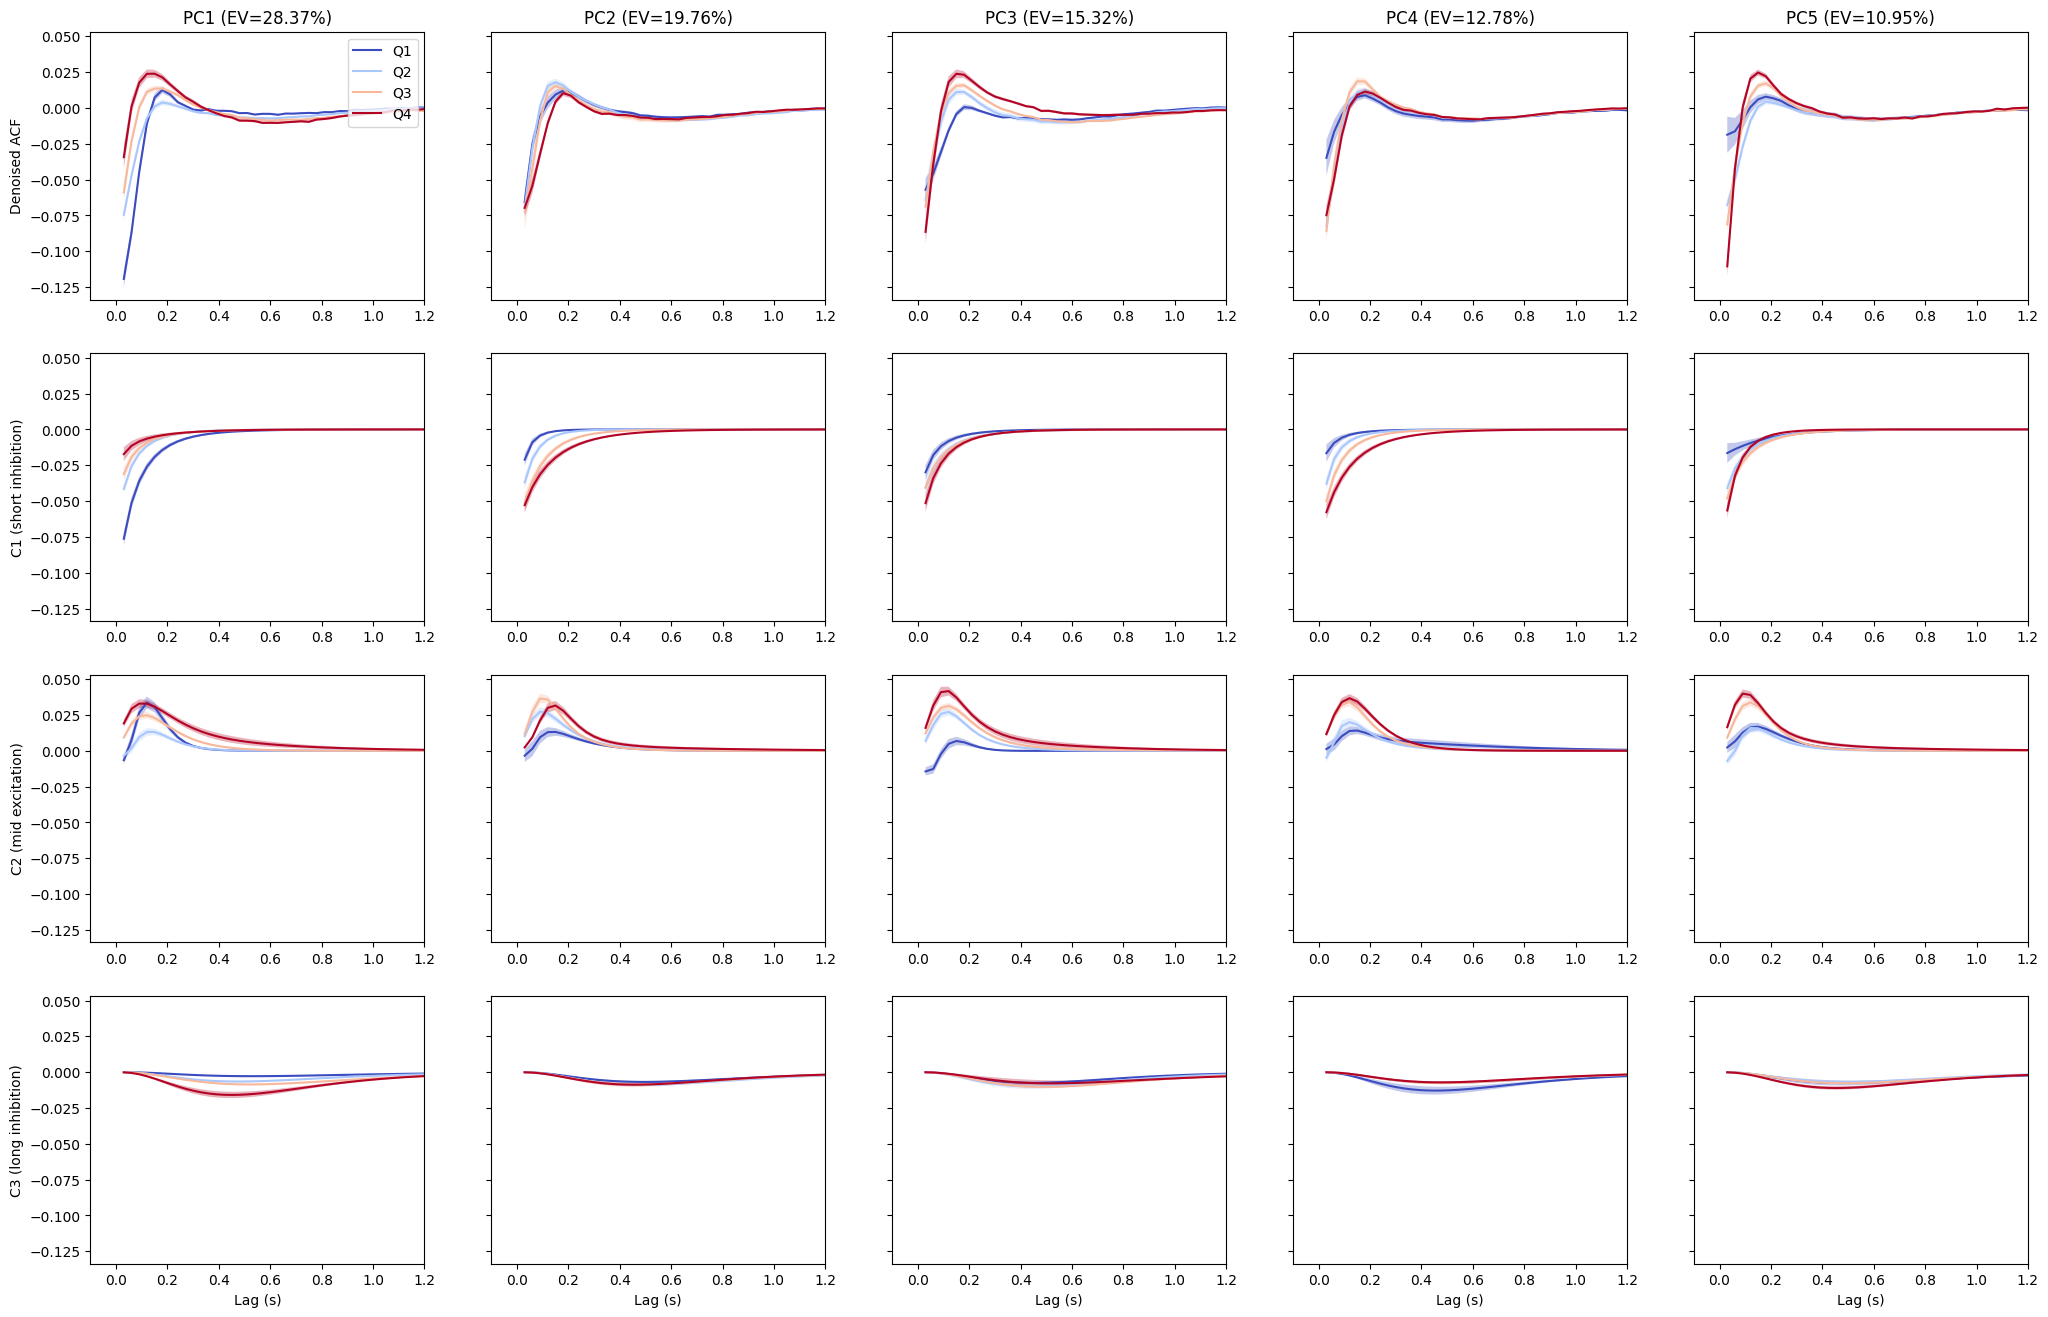

In [268]:
# mean acg, C1, C2 and C3 by each parameter quartiles
fig, axes = plt.subplots(4, pca_scores.shape[1], figsize=(5 * pca_scores.shape[1], 4*4), sharey=True)
bin_num = 4
cmap = cm.get_cmap("coolwarm", bin_num)
x_vals = np.arange(1, auto_corr_mat_denoised.shape[1]+1) * dt
for i in range(pca_scores.shape[1]):
    curr_quantile = np.quantile(pca_scores[:, i], q=np.linspace(0, 1, bin_num + 1))
    for q in range(4):
        filter = (pca_scores[:, i] >= curr_quantile[q]) & (pca_scores[:, i] < curr_quantile[q+1])
        # whole trace
        mean_acf = np.mean(auto_corr_mat_denoised[filter], axis=0)
        sem_acf = np.std(auto_corr_mat_denoised[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[0, i]
        ax.plot(x_vals, mean_acf, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_acf - sem_acf, mean_acf + sem_acf, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.legend(loc='upper right')
            ax.set_ylabel('Denoised ACF')
        ax.set_title(f'PC{i+1} (EV={explained_variance[i]:.2%})')
        # C1
        mean_C1 = np.mean(C1_mat[filter], axis=0)
        sem_C1 = np.std(C1_mat[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[1, i]
        ax.plot(x_vals, mean_C1, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_C1 - sem_C1, mean_C1 + sem_C1, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.set_ylabel('C1 (short inhibition)')
        # C2
        mean_C2 = np.mean(C2_mat[filter], axis=0)
        sem_C2 = np.std(C2_mat[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[2, i]
        ax.plot(x_vals, mean_C2, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_C2 - sem_C2, mean_C2 + sem_C2, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.set_ylabel('C2 (mid excitation)')
        # C3
        mean_C3 = np.mean(C3_mat[filter], axis=0)
        sem_C3 = np.std(C3_mat[filter], axis=0) / np.sqrt(np.sum(filter))
        ax = axes[3, i]
        ax.plot(x_vals, mean_C3, label=f"Q{q+1}", color=cmap(q / (bin_num - 1)))
        ax.fill_between(x_vals, mean_C3 - sem_C3, mean_C3 + sem_C3, alpha=0.3, facecolor = cmap(q / (bin_num - 1)), edgecolor=None)
        ax.set_xlim(-0.1, 1.2)
        if i == 0:
            ax.set_ylabel('C3 (long inhibition)')

    ax.set_xlabel('Lag (s)')

# Plot each parameter in space

In [269]:
features_combined = features_combined.merge(all_params_df, on=['session', 'unit_id'], how='right')

In [270]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
# mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]

# --- 3D anatomical points ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

In [271]:
# precompute mesh contours for each plane (for speed)
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_mm, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [272]:
from matplotlib.colors import LinearSegmentedColormap


# Custom single-color colormap: light gray → full red
colors = [(0.4, 0.4, 0.4), (0.6, 0.3, 0.3), (1.0, 0.0, 0.0)]  # RGB for low/high
cmap = LinearSegmentedColormap.from_list('custom_red', colors)

In [319]:
# perform spatial dependence analysis for all features
spatial_dependence_results = {}
focus_features = ['A1', 'tau1', 'A2', 'peak2', 'k2', 'A3', 'peak3', 'PC1', 'PC2', 'PC3', 'bl_response_corr', 'pc_1', 'pc_2', 'pc_3', 'response_rate']
filter = np.full(len(features_combined), True)  # no filter, use all neurons
filter = filter & (features_combined['PC1'] < 5)  # example filter: only include neurons with response rate > 0.5
for feature_name in focus_features:
    # if columns is numetric
    if features_combined[feature_name].dtype not in [np.float64, np.float32, np.int64, np.int32]:
        continue
    values = features_combined[feature_name].values[filter]
    result = spatial_dependence_summary(
        ccfs[filter],
        values,
        k_neighbors=30,
        n_splits=5,
        permutations=2000,
        seed=42,
    )
    spatial_dependence_results[feature_name] = result

In [321]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in spatial_dependence_results.keys()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(spatial_dependence_results.keys()):
    spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_permutation_r2'] for feat in spatial_dependence_results.keys()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(spatial_dependence_results.keys()):
    spatial_dependence_results[feature_name]['linear_trend']['p_value_permutation_r2_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results
# save results
results_file = os.path.join(target_folder, f'spatial_dependence_results_{criteria_name}.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(spatial_dependence_results, f)

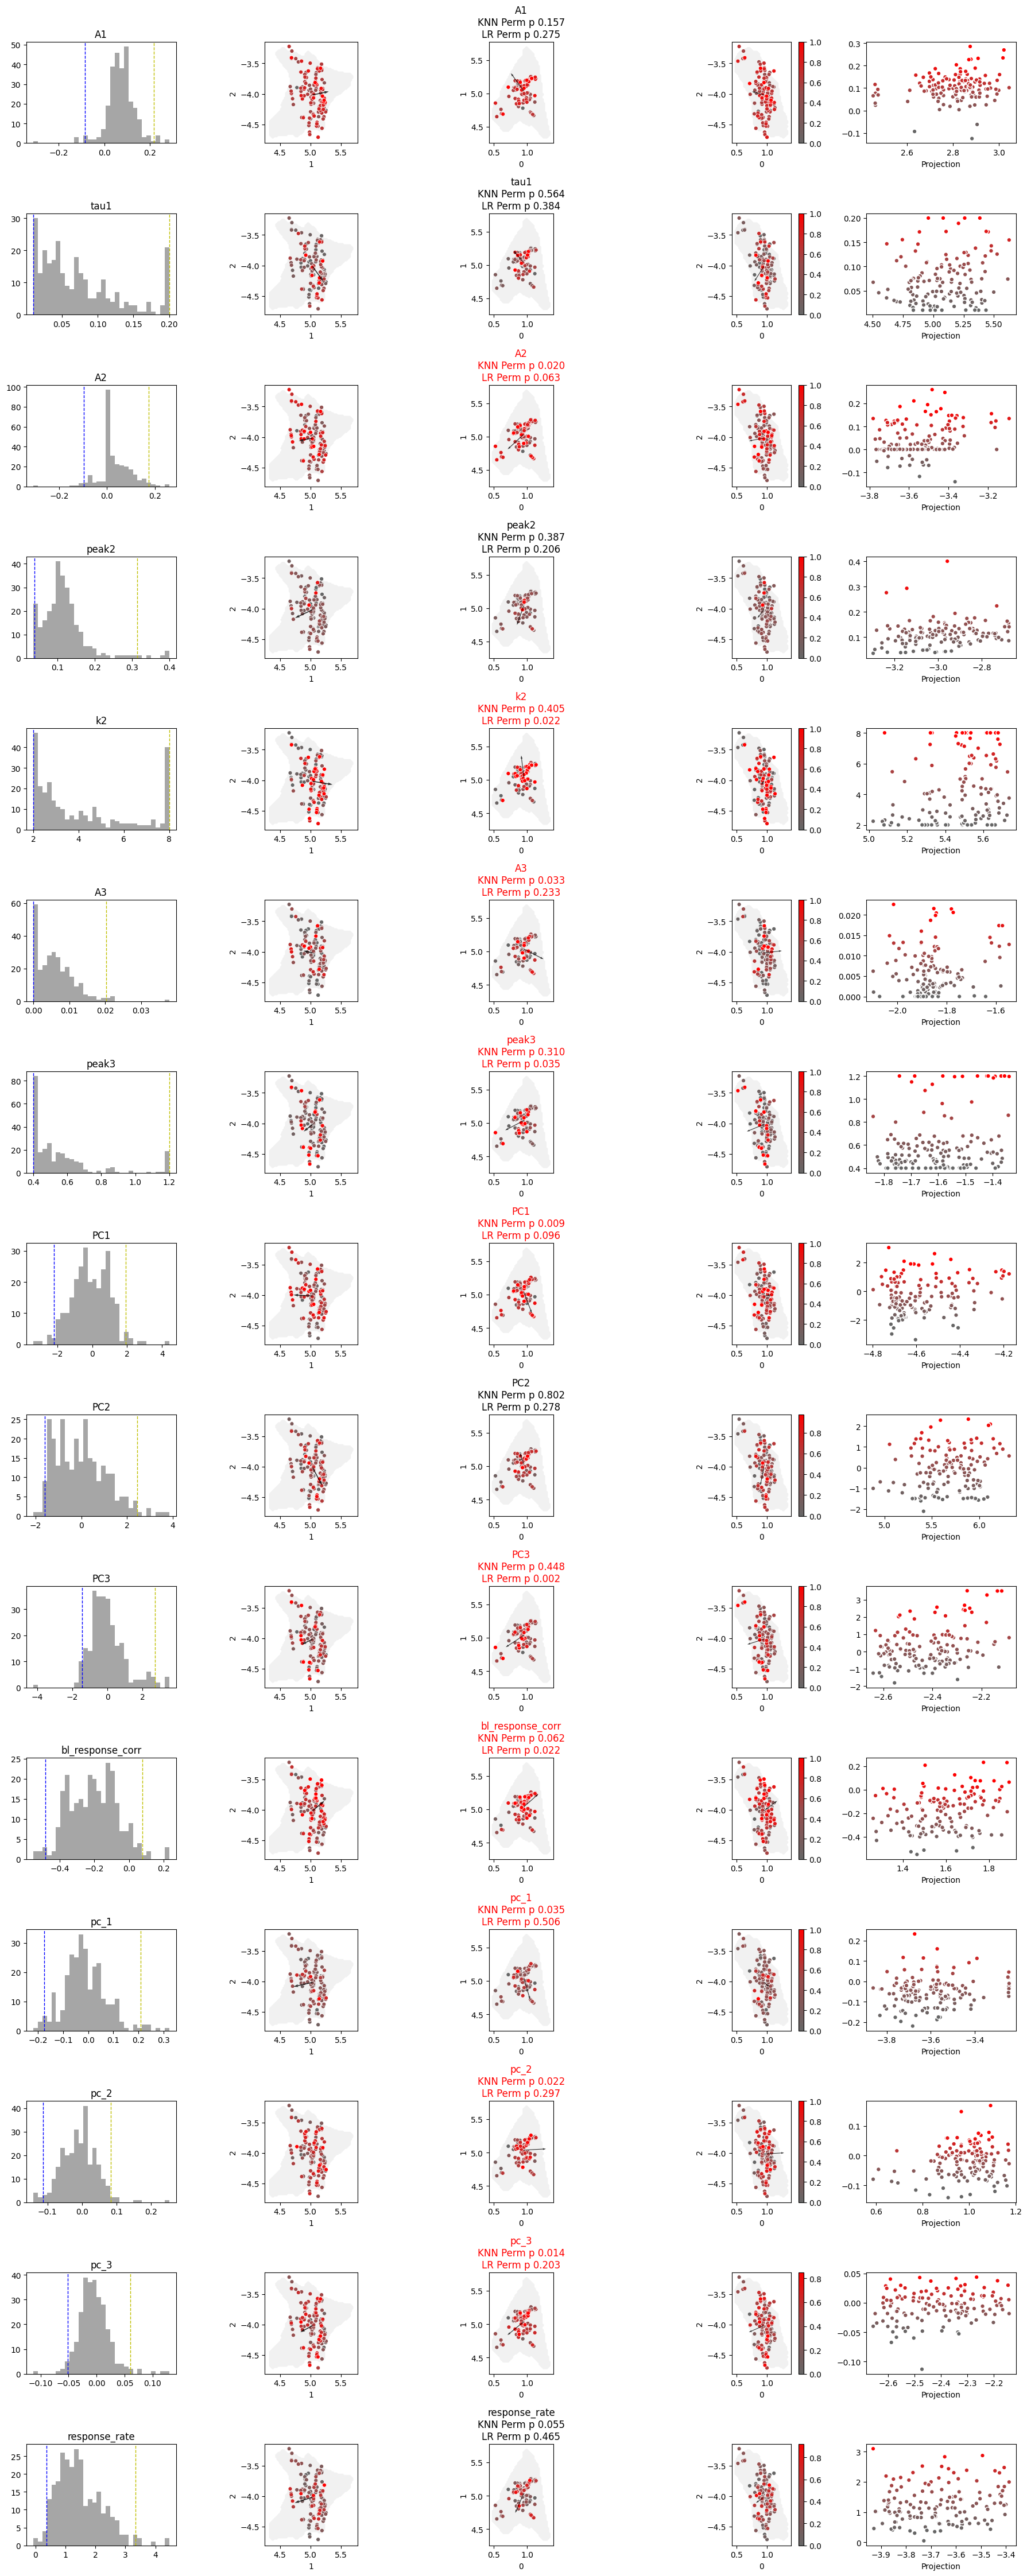

In [328]:
from matplotlib.colors import Normalize
from scipy.stats import rankdata
# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
filter = np.full(len(features_combined), True)  # no filter, use all neurons
filter = filter & (features_combined['PC1'] < 5)  # example filter: only include neurons with response rate > 0.5
# filter = features_combined['isi_violations'].values < 0.5
# CCF coordinates and planes
# ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
# bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
# ccfs = ccfs - bregma_LPS_mm
# ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bin_num = 4
# Precompute high-resolution mesh contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}
plot_features = spatial_dependence_results.keys()
fig, axes = plt.subplots(len(plot_features), 5, figsize=(18, 3*len(plot_features)))
cmap = LinearSegmentedColormap.from_list('custom_red', colors)

for ind, feature in enumerate(plot_features):
    ax = axes[ind, 0]
    color_code = features_combined[feature].values[filter]
    ax.hist(color_code, bins=30, color='gray', alpha=0.7)
    ax.set_title(feature)
    valid_ind  = ~np.isnan(color_code)
    top_90 = np.quantile(color_code[valid_ind], 0.98)
    bottom_10 = np.quantile(color_code[valid_ind], 0.02)
    ax.axvline(top_90, color='y', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
    color_code_nl = color_code.copy()
    color_code_nl[color_code > top_90] = top_90
    color_code_nl[color_code < bottom_10] = bottom_10
    color_code_nl = (color_code_nl - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles
    # change to rank
    # color_code_nl = rankdata(color_code_nl) / len(color_code_nl)
    sort_ind = np.argsort(color_code_nl)
    # sort_ind = np.random.permutation(sort_ind)  # randomize the order within same color
    # bin_edges = np.quantile(color_code, np.linspace(0, 1, bin_num + 1))
    # ax = axes[ind, -1]
    # for b in range(bin_num):
    #     bin_mask = (color_code >= bin_edges[b]) & (color_code < bin_edges[b + 1])
    #     mean_wf = np.nanmean(all_wfs_nl[filter][bin_mask], axis=0)
    #     mean_sem = np.nanstd(all_wfs_nl[filter][bin_mask], axis=0) / np.sqrt(np.sum(bin_mask))
    #     ax.plot(pc_time, mean_wf, label=f'Bin {b + 1} ({bin_edges[b]:.2f}-{bin_edges[b + 1]:.2f})', 
    #             color=cmap(b / (bin_num - 1)), linewidth=2)
    #     ax.fill_between(pc_time, mean_wf - mean_sem, mean_wf + mean_sem, color=cmap(b / (bin_num - 1)), 
    #                     alpha=0.3)
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # Plot the mesh
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
        # Plot the points
        sc = ax.scatter(ccfs[filter, :][sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], c=color_code_nl[sort_ind], cmap=cmap, s=25, edgecolor=[1, 1, 1], alpha=1, linewidth=0.5)
        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']<0.05 or spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']<0.05:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"KNN Perm p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']:.3f}\n"
                f"LR Perm p {spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']:.3f}",
                color=title_color
            )
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        # if planes[plane][1] == dv: 
        #     ax.invert_yaxis()
            # ax.set_ylim(-5, -3)
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
    # plot feature vs location along linear trend
    ax = axes[ind, -1]
    # project points onto linear trend vector
    coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
    trend_vec = np.array([coef[1], coef[2], coef[3]])
    trend_vec = trend_vec / np.linalg.norm(trend_vec)
    projections = ccfs[filter,:] @ trend_vec
    sc = ax.scatter(projections, color_code, c=color_code_nl, cmap=cmap, edgecolor=[1, 1, 1], s=30)
    ax.set_xlabel('Projection')
    

            

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'basic_ephys_feature_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'basic_ephys_feature_in_space_{criteria_name}.svg'), dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'A2 vs T_response_hit_all\nSpearman r=0.26, p=0.000')

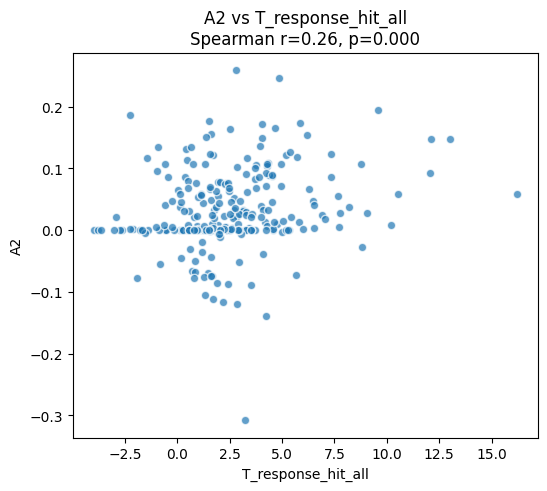

In [359]:
x_val = 'T_response_hit_all'
y_val = 'A2'
fig = plt.figure(figsize=(6, 5))
plt.scatter(features_combined[x_val][filter], features_combined[y_val][filter], alpha=0.7, cmap='viridis', edgecolors='white')
plt.xlabel(x_val)
plt.ylabel(y_val)
# correlation coef and sig
from scipy.stats import spearmanr
valid_ind = ~np.isnan(features_combined[x_val][filter]) & ~np.isnan(features_combined[y_val][filter])
corr_coef, p_value = spearmanr(features_combined[x_val][filter][valid_ind], features_combined[y_val][filter][valid_ind])
plt.title(f"{y_val} vs {x_val}\nSpearman r={corr_coef:.2f}, p={p_value:.3f}")


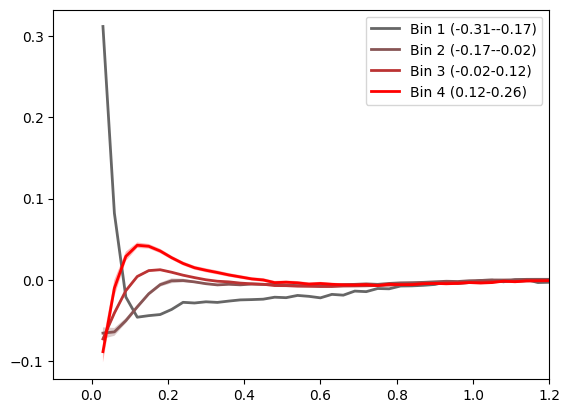

In [357]:
# CCA analysis
focus_feature = 'A2'
focus_values = features_combined[focus_feature].values[filter]
cmap = LinearSegmentedColormap.from_list('custom_red', colors)
num_bins = 4
# Bin the feature into quantiles
quantiles = np.nanquantile(focus_values, np.linspace(0, 1, num_bins + 1))
quantiles = np.linspace(np.nanmin(focus_values), np.nanmax(focus_values), num_bins + 1)  # or use equal-width bins
for b in range(num_bins):
    bin_mask = (focus_values >= quantiles[b]) & (focus_values < quantiles[b + 1])
    mean_wf = np.nanmean(auto_corr_mat_denoised[filter][bin_mask], axis=0)
    mean_sem = np.nanstd(auto_corr_mat_denoised[filter][bin_mask], axis=0) / np.sqrt(np.sum(bin_mask))
    plt.plot(x_vals, mean_wf, label=f'Bin {b + 1} ({quantiles[b]:.2f}-{quantiles[b + 1]:.2f})', color=cmap(b / (num_bins - 1)), linewidth=2)
    plt.fill_between(x_vals, mean_wf - mean_sem, mean_wf + mean_sem, color=cmap(b / (num_bins - 1)), alpha=0.3, edgecolor=None)
plt.xlim(-0.1, 1.2)
plt.legend()

## CCA

In [306]:
focus_features_cca = ['A1', 'tau1', 'A2', 'k2', 'A3', 'pc_1', 'pc_2', 'pc_3', 'bl_response_corr', 'PC1', 'PC2', 'PC3', 'response_rate']
focus_features = focus_features_cca

CCA CCF Component 1 Coefficients:
  x_ccf: 0.5034
  y_ccf: 0.6323
  z_ccf: 0.5889
CCA CCF Component 2 Coefficients:
  x_ccf: -0.3720
  y_ccf: 0.7737
  z_ccf: -0.5128
CCA CCF Component 3 Coefficients:
  x_ccf: 0.7799
  y_ccf: -0.0391
  z_ccf: -0.6247


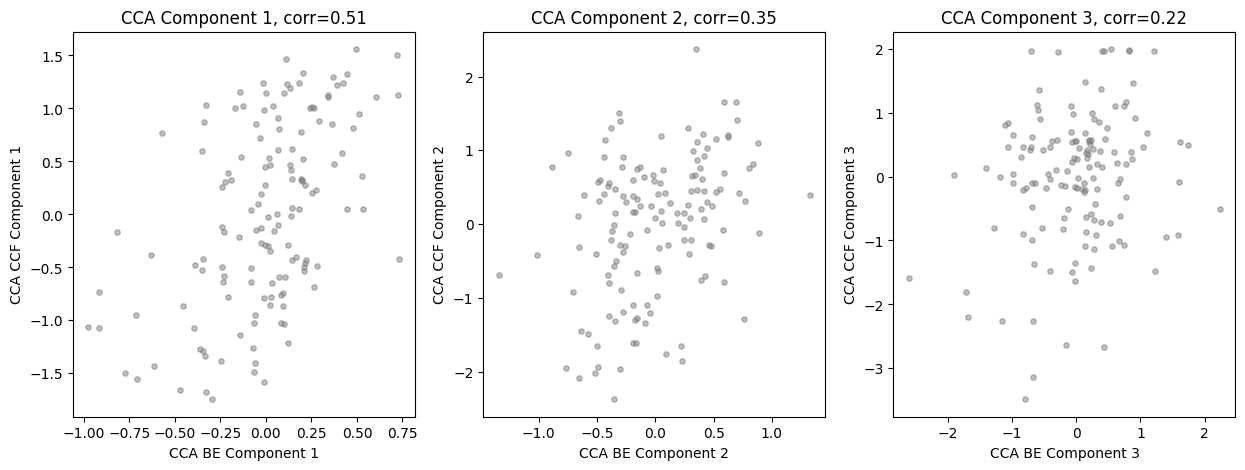

In [307]:
# cca in space
from sklearn.cross_decomposition import CCA
# filters = features_combined['isi_violations'] < 0.5
filters = np.full(len(features_combined), True)
cca_feature_mat = features_combined[focus_features].values[filter]
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left
# remove nan
nan_ind_cca = np.isnan(cca_feature_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_feature_mat = cca_feature_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]
# zscore
cca_feature_mat = zscore(cca_feature_mat, axis=0, nan_policy='omit')
# ccf_mat = zscore(ccf_mat, axis=0, nan_policy='omit')
cca = CCA(n_components=3)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_feature_mat, ccf_mat)
# plot cca result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.scatter(cca_result_be[:, i], cca_result_ccf[:, i], c='gray', alpha=0.5, s=15)
    ax.set_xlabel(f'CCA BE Component {i+1}')
    ax.set_ylabel(f'CCA CCF Component {i+1}')
    ax.set_title(f'CCA Component {i+1}, corr={np.corrcoef(cca_result_be[:, i], cca_result_ccf[:, i])[0, 1]:.2f}')
# # print coefficients
# cca_be_coeff = cca.x_weights_
# for i in range(3):
#     print(f'CCA BE Component {i+1} Coefficients:')
#     for j, feature in enumerate(focus_features):
#         print(f'  {feature}: {cca_be_coeff[j, i]:.4f}')
# print cca ccf coeff
cca_ccf_coeff = cca.y_weights_
for i in range(3):
    print(f'CCA CCF Component {i+1} Coefficients:')
    for j, axis in enumerate(['x_ccf', 'y_ccf', 'z_ccf']):
        print(f'  {axis}: {cca_ccf_coeff[j, i]:.4f}')


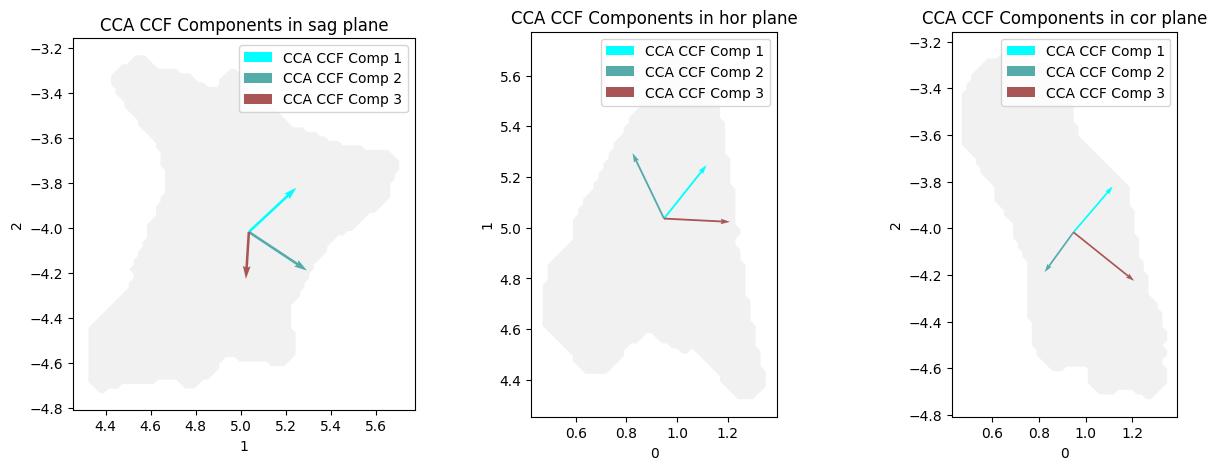

In [308]:
# plot cca ccf components weight in space as vector in ccf space with mesh
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, 1, 1), (0.5, 0.5, 0.5), (1.0, 0.0, 0.0)]
)
for plane_ind, plane in enumerate(planes.keys()):
    ax = axes[plane_ind]
    for c in mesh_contours[plane]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    for i in range(3):
        vec = cca_ccf_coeff[:, i]
        # normalize vector for better visualization
        vec = vec / np.linalg.norm(vec)
        origin = np.nanmean(ccf_mat, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=custom_cmap(i/3))
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')
    ax.set_title(f'CCA CCF Components in {plane} plane')
    ax.legend(loc='upper right')

In [309]:
nan_ind_cca.shape

(280,)

In [310]:
# bin waveforms by cca component 1
cca_comp_1 = cca_result_be[:, 0]
num_bins = 3
fig = plt.figure(figsize=(8, 6))
bin_edges = np.quantile(cca_comp_1, np.linspace(0, 1, num_bins + 1))
bin_edges = np.linspace(np.nanmin(cca_comp_1), np.nanmax(cca_comp_1), num_bins + 1)  # or use equal-width bins
for i in range(num_bins):
    bin_mask = (cca_comp_1 >= bin_edges[i]) & (cca_comp_1 < bin_edges[i + 1])
    mean_acg = np.nanmean(auto_corr_mat_denoised[~nan_ind_cca][bin_mask], axis=0)
    plt.plot(x_vals, mean_acg, label=f'Bin {i + 1}', c = custom_cmap(i / (num_bins - 1)))
plt.xlabel('Time (s)')
# fig.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_cca_comp1_{criteria_name}.pdf'))
# plt.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_cca_comp1_{criteria_name}.svg'))

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, 'T_baseline_hit_all vs CCA Component 1\nSpearman r=0.01, p=0.879')

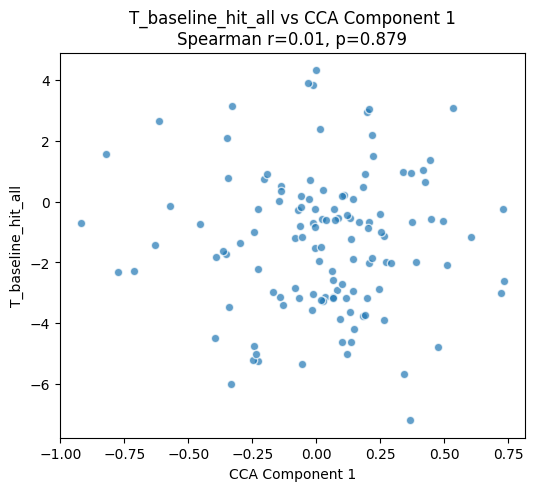

In [312]:
# plot cca component 1 vs feature
curr_feature = 'T_baseline_hit_all'
fig = plt.figure(figsize=(6, 5))
plt.scatter(cca_comp_1, features_combined[curr_feature].values[filter][~nan_ind_cca], alpha=0.7, edgecolors='white')
plt.xlabel('CCA Component 1')
plt.ylabel(curr_feature)
# correlation coef and sig
valid_ind = ~np.isnan(cca_comp_1) & ~np.isnan(features_combined[curr_feature].values[filter][~nan_ind_cca])
corr_coef, p_value = spearmanr(cca_comp_1[valid_ind], features_combined[curr_feature].values[filter][~nan_ind_cca][valid_ind])
plt.title(f"{curr_feature} vs CCA Component 1\nSpearman r={corr_coef:.2f}, p={p_value:.3f}")

In [ ]:
# # pick example units from each cca_1 bin and scatter in space
# example_units = []
# ccf_valid = np.all(~np.isnan(ccfs), axis=1)
# num_bins = 3
# bin_edges = np.quantile(cca_comp_1, np.linspace(0, 1, num_bins + 1))
# all_wfs_nl_clean_cca = all_wfs_nl_clean[~nan_ind_cca]
# for i in range(num_bins):
#     bin_mask = (cca_comp_1 >= bin_edges[i]) & (cca_comp_1 < bin_edges[i + 1])
#     bin_indices = np.where(bin_mask)[0]
#     if len(bin_indices) > 0:
#         # randomly select one unit from the bin
#         example_units.append(np.random.choice(bin_indices))
# example_units = np.array([np.int64(69), np.int64(58), np.int64(65)])
# print('Example units selected:', example_units)
# cca_values = cca_comp_1
# low, high = np.nanquantile(cca_values, [0.02, 0.98])
# pc_values_nl = np.clip(cca_values, low, high)
# pc_values_nl = (pc_values_nl - low) / (high - low)
# pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# for plane_ind, (plane_name, plane_axes) in enumerate(planes.items()):
#     ax = axes[plane_ind]
#     # fill mesh projection contours
#     for c in mesh_contours[plane_name]:
#         ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
#     proj_ccf = ccfs[~nan_ind_cca][:, plane_axes]
#     sc = ax.scatter(
#         proj_ccf[example_units, 0], proj_ccf[example_units, 1],
#         c=pc_values_nl[example_units], cmap=custom_cmap, vmin=0, vmax=1,
#         s=50, edgecolor=[1, 1, 1], alpha=1
#     )
    
#     ax.set_aspect('equal')
#     ax.set_xlabel(f'Axis {plane_axes[0]}')
#     ax.set_ylabel(f'Axis {plane_axes[1]}')
#     ax.set_title(f'Example Units in {plane_name} Plane')
#     ax.legend()

# # plot waveform on the last axis
# ax = axes[3]
# for i, unit_idx in enumerate(example_units):
#     mean_wf = all_wfs_nl_clean_cca[unit_idx]
#     ax.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(pc_values_nl[unit_idx]))
# ax.set_xlabel('Time (ms)')
# ax.set_title('Example Unit Waveforms')
# plt.tight_layout()
# plt.savefig(os.path.join(target_folder, f'wf_cca1_binned_waveforms_and_examples_{criteria_name}.pdf'),
#             dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(target_folder, f'wf_cca1_binned_waveforms_and_examples_{criteria_name}.svg'),
#             dpi=300, bbox_inches='tight')

# Bootstrapping

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cross_decomposition import CCA
from collections import defaultdict
alpha = 0.05
ranked = False
# ==========================================================
#   0. ORIGINAL CCA FIT
# ==========================================================
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['isi_violations'].values < 0.5
cca_be_mat = features_combined[focus_features].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
# score
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')

if ranked:
    ccf_mat = ccf_mat_ranked

cca = CCA(n_components=2)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

xw = cca.x_weights_.copy()
yw = cca.y_weights_.copy()

n_samples = cca_be_mat.shape[0]
n_features_be = cca_be_mat.shape[1]

# normalized anatomical CCA vectors
cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)


# ==========================================================
#   1. BIN DATA INTO 3D VOXELS
# ==========================================================

coords = ccf_mat  # N×3 anatomical points

# choose bin counts
n_bins_xyz = (2, 3, 3)

bins = [
    np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
    for i in range(3)
]

xbin = np.digitize(coords[:, 0], bins[0]) - 1
ybin = np.digitize(coords[:, 1], bins[1]) - 1
zbin = np.digitize(coords[:, 2], bins[2]) - 1

# voxel → sample indices
voxel_map = defaultdict(list)
for i in range(len(coords)):
    v = (xbin[i], ybin[i], zbin[i])
    voxel_map[v].append(i)

valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]

# number of points per voxel
counts = np.array([len(voxel_map[v]) for v in valid_voxels])
total_count = counts.sum()

# compute proportional sample counts per voxel
samples_per_voxel = np.maximum(
    1,  # ensure every voxel contributes
    np.floor((counts / total_count) * n_samples).astype(int)
)


# ==========================================================
#   2. BOOTSTRAP LOOP WITH PROPORTIONAL SAMPLING
# ==========================================================

n_boot = 1000
rng = np.random.default_rng(4)

boot_xw = np.zeros((n_boot, n_features_be, 2))
boot_yw = np.zeros((n_boot, 3, 2))

for b in range(n_boot):
    indices = []

    # sample proportionally from each voxel
    for vox_idx, voxel in enumerate(valid_voxels):
        n_draw = voxel_map[voxel].__len__()

        picked = rng.choice(
            voxel_map[voxel],
            size=n_draw,
            replace=True
        )
        indices.extend(picked)

    indices = np.array(indices)

    Xb = cca_be_mat[indices]
    Yb = ccf_mat[indices]

    cca_b = CCA(n_components=2)
    cca_b.fit(Xb, Yb)

    boot_xw[b] = cca_b.x_weights_
    boot_yw[b] = cca_b.y_weights_

# ==========================================================
#  SIGN ALIGNMENT (recommended)
# ==========================================================

boot_yw_aligned = boot_yw.copy()
boot_xw_aligned = boot_xw.copy()

boot_yw_norm = (
    boot_yw_aligned /
    np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
)

for comp in range(2):
    ref = cca_vecs[:, comp]
    for b in range(n_boot):
        if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
            boot_yw_aligned[b, :, comp] *= -1
            boot_xw_aligned[b, :, comp] *= -1




boot_yw = boot_yw_aligned.copy()
boot_xw = boot_xw_aligned.copy()
# compute CI bounds
xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)

yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

# ================================================================
#                   PRINT RESULTS WITH CI
# ================================================================
print("\n===== Behavior → CCA Weights (x_weights_) =====\n")
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, feat in enumerate(focus_features_cca):
        mean_w = xw[j, comp]
        lo = xw_low[j, comp]
        hi = xw_high[j, comp]
        print(f"  {feat:20s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()

print("\n===== CCF → CCA Weights (y_weights_) =====\n")
axes = ['x_ccf', 'y_ccf', 'z_ccf']
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, axname in enumerate(axes):
        mean_w = cca_vecs[j, comp]
        lo = yw_low[j, comp]
        hi = yw_high[j, comp]
        print(f"  {axname:10s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()


===== Behavior → CCA Weights (x_weights_) =====

Component 1:
  A1                    mean=+0.7113,  CI=(-0.5494, +0.7613)
  tau1                  mean=+0.0542,  CI=(-0.1824, +0.2488)
  A2                    mean=-0.1602,  CI=(-0.4967, +0.1439)
  k2                    mean=+0.0595,  CI=(-0.4136, +0.2347)
  A3                    mean=+0.1250,  CI=(-0.1255, +0.5216)
  pc_1                  mean=+0.5512,  CI=(-0.6861, +0.6931)
  pc_2                  mean=+0.3493,  CI=(-0.0957, +0.5793)
  pc_3                  mean=-0.0538,  CI=(-0.3466, +0.0876)
  bl_response_corr      mean=+0.1330,  CI=(-0.0624, +0.4986)

Component 2:
  A1                    mean=-0.0028,  CI=(-0.6987, +0.3266)
  tau1                  mean=-0.1409,  CI=(-0.4882, +0.3531)
  A2                    mean=-0.0371,  CI=(-0.5764, +0.4970)
  k2                    mean=-0.3535,  CI=(-0.6540, +0.2993)
  A3                    mean=+0.4700,  CI=(-0.3954, +0.7404)
  pc_1                  mean=-0.4511,  CI=(-0.7056, +0.1776)
  pc_2  

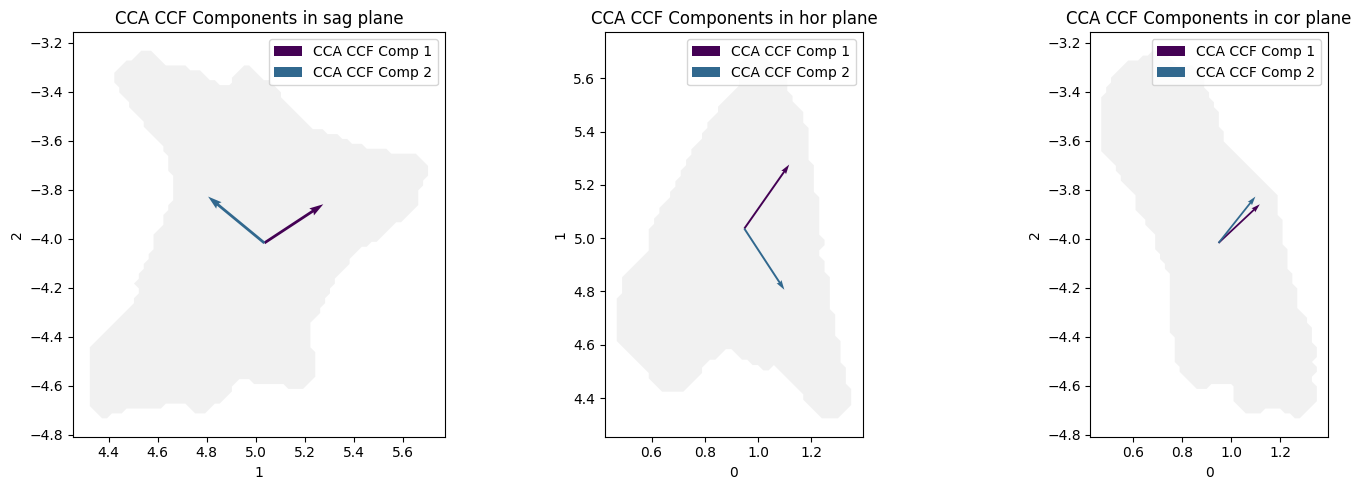

In [ ]:
# plot cca ccf components weight in space as vector in ccf space with mesh
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left
for plane_ind, plane in enumerate(planes.keys()):
    ax = axes[plane_ind]
    for c in mesh_contours[plane]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    for i in range(2):
        vec = cca_vecs[:, i].copy()
        # normalize vector for better visualization
        # vec = vec / np.linalg.norm(vec)
        origin = np.nanmean(ccf_mat, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')
    ax.set_title(f'CCA CCF Components in {plane} plane')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_CCF_components_in_space.pdf'), bbox_inches='tight')

In [ ]:
boot_yw_norm = boot_yw_aligned.copy()
# boot_yw_norm = boot_yw_aligned
origin = np.nanmean(ccf_mat, axis=0)

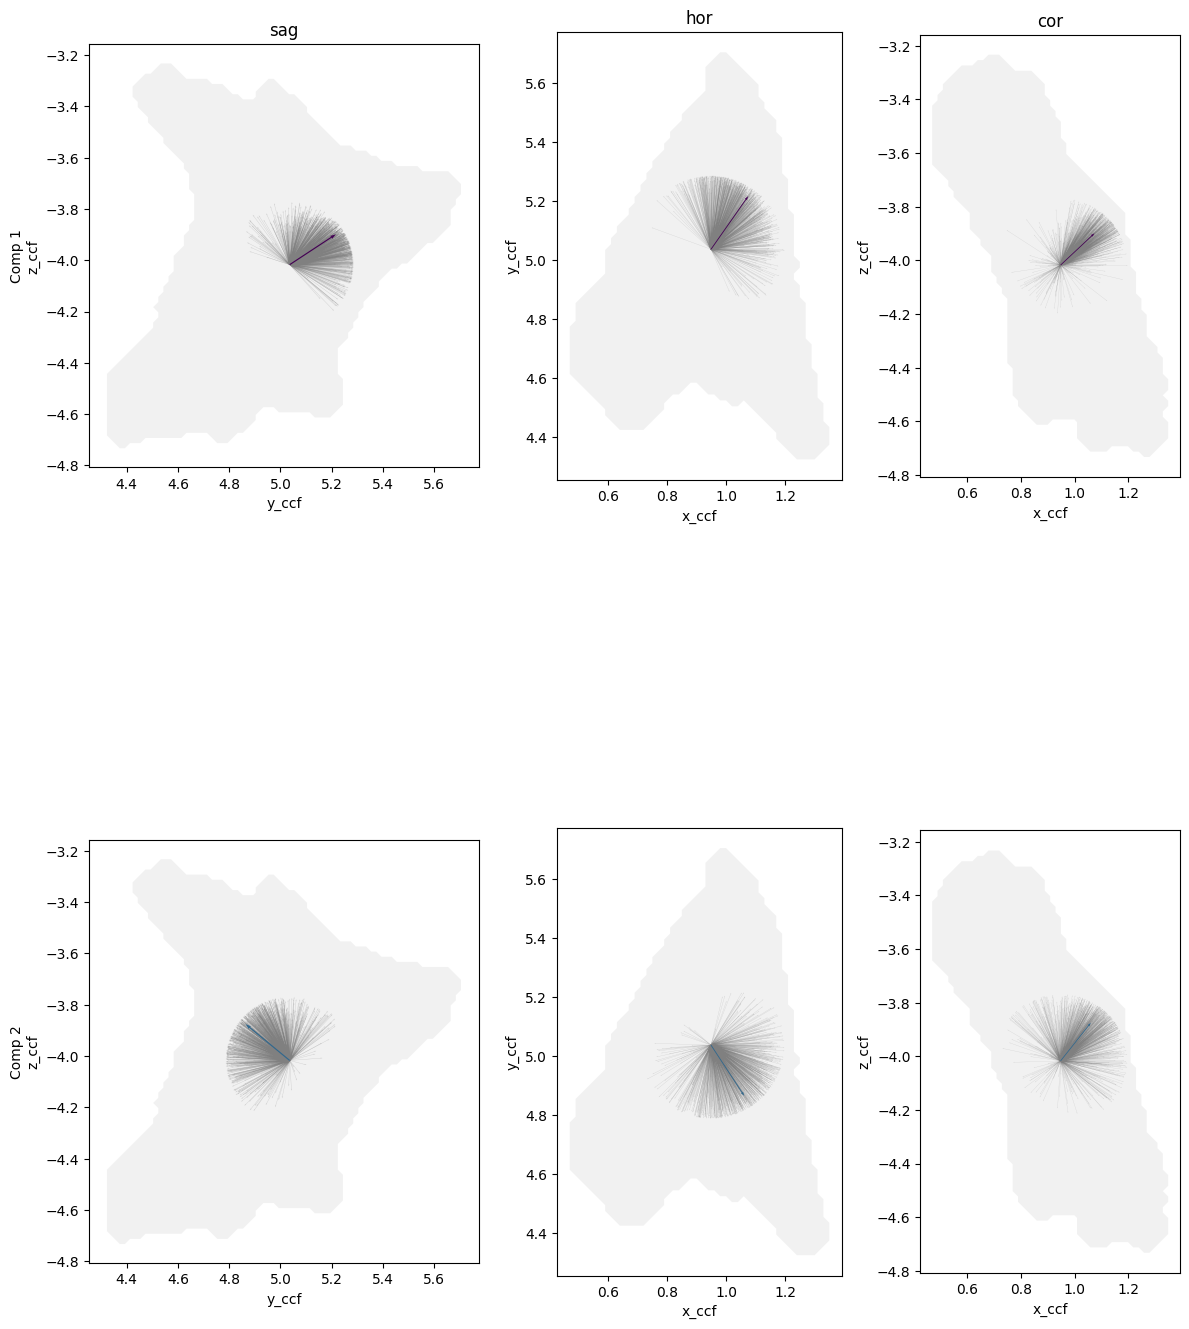

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ----- Setup 3 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
# cca_vecs = cca_ccf_coeff.copy()
# cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = boot_yw_norm[b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp].copy()

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
# plt.savefig(
#     os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
#     bbox_inches='tight'
# )
plt.show()


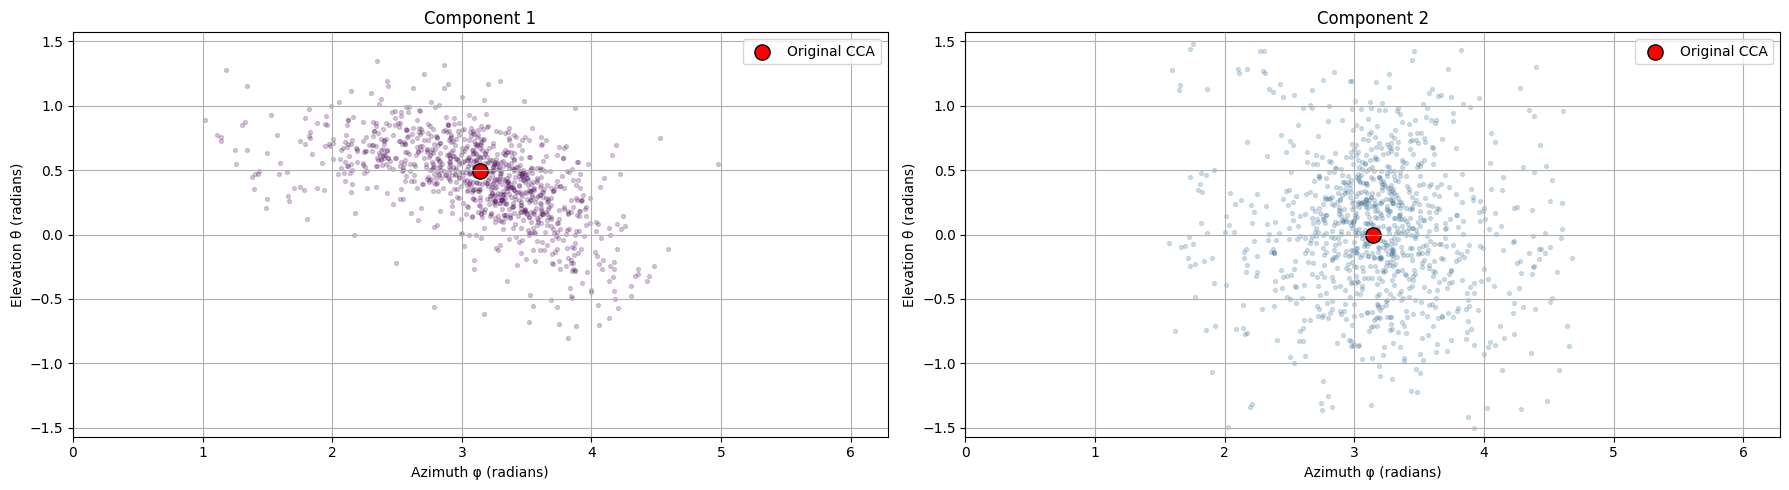

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ----- Convert vectors → spherical angles -----

# def vector_to_angles(v):
#     """Return (azimuth phi, elevation theta) for vector v."""
#     x, y, z = v
#     phi = np.arctan2(y, x)                     # horizontal angle
#     theta = np.arctan2(z, np.sqrt(x*x + y*y))  # vertical angle
#     return phi, theta


def vector_to_angles(v, off_set = 0.2):
    """Return (phi_new, theta) where φ=1 rad maps to φ_new=0."""
    x, y, z = v

    # raw azimuth φ in [0, 2π)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2 * np.pi

    # shift reference so φ=1 → φ_new=0
    phi_new = phi + off_set
    if phi_new < 0:
        phi_new += 2 * np.pi
    elif phi_new >= 2*np.pi:
        phi_new -= 2 * np.pi

    # elevation θ stays the same
    theta = np.arctan2(z, np.sqrt(x*x + y*y))

    return phi_new, theta

def express_in_basis(v, a):
    """
    Express vector v in a new coordinate system where:
      - z-axis is aligned with vector a
      - x- and y-axes are orthogonal to a (right-handed system)

    Returns:
        v_new : np.ndarray
            Coordinates of v in the new (x, y, z=a) basis
        R : np.ndarray
            3×3 rotation matrix (columns are the new basis vectors)
    """
    a = np.asarray(a, dtype=float)
    v = np.asarray(v, dtype=float)

    # Normalize z-axis (the reference direction)
    z_axis = a / np.linalg.norm(a)

    # Pick a stable arbitrary vector not parallel to z
    if abs(z_axis[0]) < 0.9:
        tmp = np.array([1, 0, 0])
    else:
        tmp = np.array([0, 1, 0])

    # Build x-axis orthogonal to z (Gram–Schmidt)
    x_axis = tmp - np.dot(tmp, z_axis) * z_axis
    x_axis /= np.linalg.norm(x_axis)

    # y-axis = z × x (right-handed system)
    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.linalg.norm(y_axis)

    # Rotation matrix: columns are new basis vectors
    R = np.column_stack([x_axis, y_axis, z_axis])

    # Express v in new basis
    v_new = R.T @ v

    return v_new, R

# Compute angles for bootstrap samples
phi_boot = np.zeros((n_boot, 2))
theta_boot = np.zeros((n_boot, 2))

# Compute angles for original CCA vectors
phi_orig = np.zeros(2)
theta_orig = np.zeros(2)
comp = 0
v0 = cca_vecs[:, comp].copy()   # normalized
phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=np.pi - np.arctan2(v0[1], v0[0]))
comp = 1
v1 = cca_vecs[:, comp].copy()   # normalized
v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set= -np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)

# for component 0
comp = 0
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi - np.arctan2(v0[1], v0[0]))

# for component 1
comp = 1
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    # project v onto plane orthogonal to component 0
    v_proj, R = express_in_basis(v, cca_vecs[:, 0])
    # convert projected 2D vector to angles
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj, off_set=-np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)



# ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for comp in range(2):
    ax = axes[comp]
    
    ax.scatter(
        phi_boot[:, comp],
        theta_boot[:, comp],
        s=8, alpha=0.2,
        color=cm.viridis(comp/3)
    )
    
    # Plot original CCA direction
    ax.scatter(
        phi_orig[comp],
        theta_orig[comp],
        s=120, color='red', edgecolor='black', label='Original CCA'
    )

    ax.set_title(f'Component {comp+1}')
    ax.set_xlabel('Azimuth φ (radians)')
    ax.set_ylabel('Elevation θ (radians)')
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
# plt.savefig(os.path.join(target_folder, 'CCA_direction_angle_scatter.pdf'),
#             bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

def kth_percentile_contour_levels(values, kde, xx, yy, levels=[0.1, 0.3, 0.5, 0.9]):
    """
    Convert percentile levels into actual KDE contour threshold values.

    Parameters
    ----------
    values : ndarray
        Flattened KDE values (e.g., kde(np.vstack([xx.ravel(), yy.ravel()]))).
    kde : gaussian_kde
        KDE object (not used in computation, kept for compatibility).
    xx, yy : ndarray
        Meshgrid arrays corresponding to evaluation grid (not used directly).
    levels : list of float
        Percentiles as fractions of total probability mass (e.g. [0.1, 0.3, 0.5, 0.9]).

    Returns
    -------
    contour_levels : list of float
        Density thresholds corresponding to requested cumulative probabilities.
    """
    # Sort KDE density values in descending order
    sorted_vals = np.sort(values)[::-1]

    # Compute normalized cumulative sum
    cumsum = np.cumsum(sorted_vals)
    cumsum /= cumsum[-1]  # normalize to 1

    contour_levels = []
    for p in levels:
        # smallest density threshold such that area above it = p
        # use interpolation for smoother results
        idx = np.searchsorted(cumsum, p)
        if idx >= len(sorted_vals):
            idx = len(sorted_vals) - 1
        contour_levels.append(sorted_vals[idx])

    return contour_levels

# -----------------------------------------------------------
# φ–θ DENSITY CONTOUR PLOT (10%, 30%, 50%, 90%) + marginals
# -----------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for comp in range(2):
    ax = axes[comp]

    # KDE over φ–θ samples
    data = np.vstack([phi_boot[:, comp], theta_boot[:, comp]])
    kde = gaussian_kde(data, bw_method=0.3)

    # grid for density evaluation
    phi_grid = np.linspace(0, 2*np.pi, 300)
    theta_grid = np.linspace(-np.pi/2, np.pi/2, 300)
    xx, yy = np.meshgrid(phi_grid, theta_grid)
    zz = kde(np.vstack([xx.flatten(), yy.flatten()]))
    zz_grid = zz.reshape(xx.shape)

    # scatter bootstraps
    ax.scatter(phi_boot[:, comp], theta_boot[:, comp],
               s=8, alpha=0.2, color=cm.viridis(comp/3))

    # percentile contour levels
    contour_levels = kth_percentile_contour_levels(
        zz, kde, xx, yy, levels=[0.10, 0.30, 0.50, 0.90]
    )
    contour_levels_sorted = np.sort(contour_levels)

    # density background
    ax.imshow(
        zz_grid, origin='lower',
        extent=[0, 2*np.pi, -np.pi/2, np.pi/2],
        aspect='auto', cmap='Blues', alpha=0.3
    )

    # main contours
    cs = ax.contour(
        xx, yy, zz_grid,
        levels=contour_levels_sorted,
        colors=["black", "blue", "purple", "red"],
        linewidths=[1.5, 2.0, 2.5, 3.0]
    )
    fmt = {val: label for val, label in zip(contour_levels_sorted, ["10%", "30%", "50%", "90%"])}
    ax.clabel(cs, inline=True, fontsize=10, fmt=fmt)

    # original CCA direction
    ax.scatter(phi_orig[comp], theta_orig[comp],
               s=100, color='yellow', edgecolor='black', zorder=5,
               label="Original CCA direction")

    # axis settings
    if comp == 0:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to CCF')
    else:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to Comp 1')
    ax.set_xlabel("Azimuth φ (radians)")
    ax.set_ylabel("Elevation θ (radians)")
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

    # -------------------------------------------------------
    # MARGINAL HISTOGRAMS (top and right)
    # -------------------------------------------------------
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", size=1.0, pad=0.3, sharex=ax)
    ax_histy = divider.append_axes("right", size=1.0, pad=0.3, sharey=ax)

    # Hide tick labels on hist axes
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)

    # Plot histograms
    ax_histx.hist(phi_boot[:, comp], bins=40, color='gray', alpha=0.7)
    ax_histy.hist(theta_boot[:, comp], bins=40, orientation='horizontal', color='gray', alpha=0.7)

    # Match limits
    ax_histx.set_xlim(ax.get_xlim())
    ax_histy.set_ylim(ax.get_ylim())

    # Simplify look
    for spine in ax_histx.spines.values():
        spine.set_visible(False)
    for spine in ax_histy.spines.values():
        spine.set_visible(False)

# plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_direction_angle_density_contours_with_marginals.pdf'),
    bbox_inches='tight'
)
plt.show()

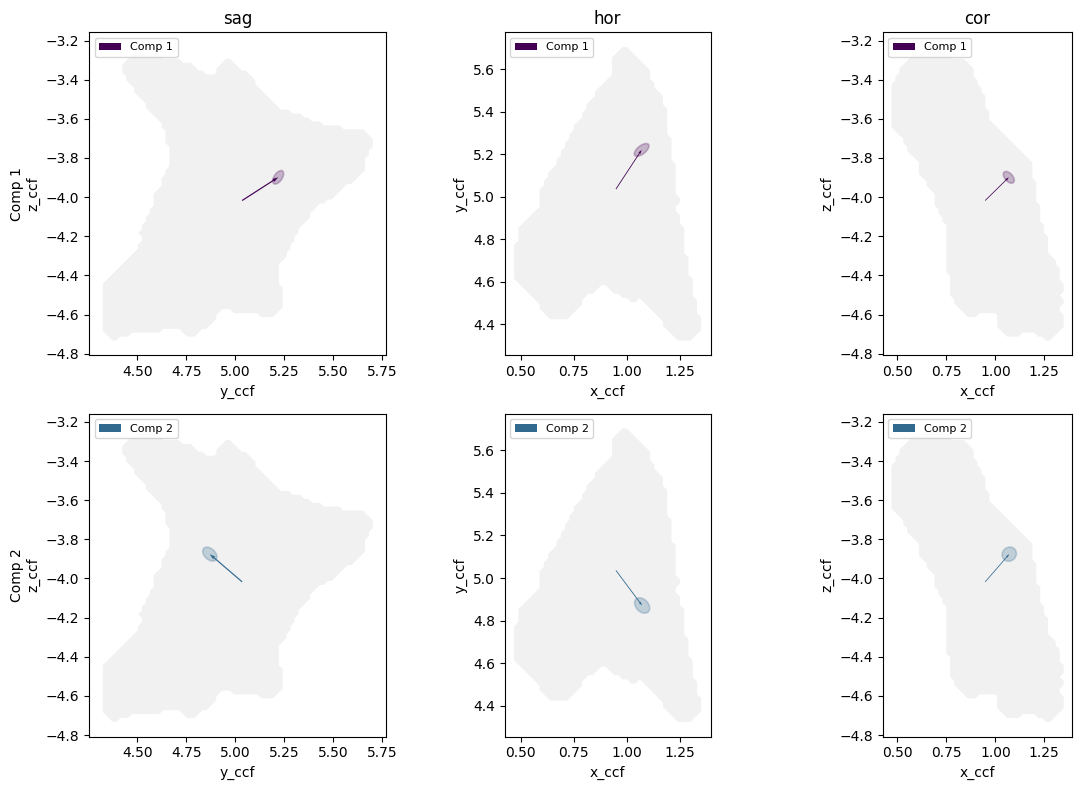

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # Collect bootstrap vectors for this component
        boot_vecs = boot_yw_norm[:, :, comp]
        # Mean vector
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # Project all bootstrap vectors to the plane (ix, iy)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        # Compute 2D covariance for cone/ellipse (bootstrapped spread)
        cov = np.cov(vecs_2d.T)

        # Convert covariance to *standard error* ellipse
        eigvals, eigvecs = np.linalg.eigh(cov / n_boot)  # divide by n_boot for SE

        # Scale by desired number of SEs (e.g., 1 → 1 SE, 2 → 95% CI)
        width, height = 2 * n_se * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

        scale = 1/0.25  # scaling factor for arrow length
        end_x = origin[ix] + mean_2d[0] / scale
        end_y = origin[iy] + mean_2d[1] / scale

        # Ellipse centered at arrow tip
        ellipse = Ellipse(
            xy=(end_x, end_y),
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)

        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.004, linewidth=1.0,
            label=f'Comp {comp+1}'
        )

        # ----------------------------
        # OPTIONAL: TRUE CCA VECTOR
        # ----------------------------
        # true_vec = cca_vecs[:, comp]
        # ax.quiver(
        #     origin[ix], origin[iy],
        #     true_vec[ix], true_vec[iy],
        #     angles='xy', scale_units='xy', scale=1/0.25,
        #     color='black', width=0.002, linewidth=0.5,
        #     alpha=0.8, label='Original CCA'
        # )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, f'CCA_CCF_components_bootstrap_{n_se}_SE_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
# cca_vecs = cca_ccf_coeff.copy()
# cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
ci = 0.95
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        from scipy.stats import chi2
        # central 90% CI == 5% to 95%
        chi2_val = chi2.ppf(ci, df=2) # 2D chi-square quantile
        scale_ci = np.sqrt(chi2_val)

        boot_vecs = boot_yw_norm[:, :, comp]  # (n_boot, 3)
        # normalize each bootstrap vector (important if not already)
        boot_vecs = boot_vecs / np.linalg.norm(boot_vecs, axis=1, keepdims=True)

        # Mean vector (unit norm)
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # 2D projected direction (unit norm in 3D; 2D length varies)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        scale = 1/0.25  # your arrow scaling factor

        # --- Work in endpoint space (matches what you plot) ---
        endpts = np.column_stack([
            origin[ix] + vecs_2d[:, 0] / scale,
            origin[iy] + vecs_2d[:, 1] / scale,
        ])

        # Center ellipse at the mean endpoint
        end_mean = np.array([
            origin[ix] + mean_2d[0] / scale,
            origin[iy] + mean_2d[1] / scale,
        ])

        # Covariance of endpoints (NOT divided by n_boot)
        cov = np.cov(endpts.T)

        # Eigen-decomposition for ellipse axes
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        # Ellipse parameters for 90% CI
        width, height = 2 * scale_ci * np.sqrt(eigvals)  # factor 2 because width/height are full lengths
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

        ellipse = Ellipse(
            xy=end_mean,
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)


        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.004, linewidth=1.0,
            label=f'Comp {comp+1}'
        )

        # ----------------------------
        # OPTIONAL: TRUE CCA VECTOR
        # ----------------------------
        # true_vec = cca_vecs[:, comp]
        # ax.quiver(
        #     origin[ix], origin[iy],
        #     true_vec[ix], true_vec[iy],
        #     angles='xy', scale_units='xy', scale=1/0.25,
        #     color='black', width=0.002, linewidth=0.5,
        #     alpha=0.8, label='Original CCA'
        # )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, f'CCA_CCF_components_bootstrap_{ci}%_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
cca_be_coeff = cca.x_weights_.copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax = axes[i]
    ax.bar(focus_features_cca, cca.x_weights_[:, i], color='gray', alpha=0.7)
    ax.set_title(f'CCA BE Component {i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features_cca, rotation=45, ha='right')
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'CCA_wf_components_loadings.pdf'), bbox_inches='tight')

In [ ]:

from scipy.ndimage import binary_dilation

# -------------------------------------------------------------------------
# Helper: project 3D mesh to 2D contours
# -------------------------------------------------------------------------
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (0, 1, 1)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (1, 0, 0))])

# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(15, 10))

# CCF coordinates and planes
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

for dim_ind in range(2):
    cca_values = cca_result_be[:, dim_ind].copy()

    # Clip and normalize color values
    low, high = np.nanquantile(cca_values, [0.02, 0.98])
    cca_values_nl = np.clip(cca_values, low, high)
    cca_values_nl = (cca_values_nl - low) / (high - low)
    # cca_values_nl[np.isnan(cca_values_nl)] = 0.0
    # rank it
    cca_values_nl = rankdata(cca_values_nl) / len(cca_values_nl)
    ax = axes[dim_ind, 0]
    ax.hist(cca_values, bins=30, color='gray', alpha=0.7)
    ax.axvline(low, linestyle='--', label='bottom', color=custom_cmap(0.00000001))
    ax.axvline(high, linestyle='--', label='top', color=custom_cmap(0.99999999))
    sort_ind = np.argsort(cca_values_nl)
    # randomize order within ties
    sort_ind = np.random.permutation(sort_ind)

    for j, (plane_name, plane_axes) in enumerate(planes.items()):
        ax = axes[dim_ind, j+1]

        # --- fill mesh projection contours ---
        for c in mesh_contours[plane_name]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # --- scatter of projected CCF points ---
        proj_ccf = ccfs[:, plane_axes]
        sc = ax.scatter(
            proj_ccf[sort_ind, 0], proj_ccf[sort_ind, 1],
            c=cca_values_nl[sort_ind], cmap=custom_cmap,
            s = 70, edgecolor='white', alpha=1, linewidth=1
        )

        # --- plot CCA direction vector ---
        vec = cca_vecs[:, dim_ind].copy()
        origin = np.nanmean(ccfs, axis=0)
        ax.quiver(origin[plane_axes[0]], origin[plane_axes[1]],
                  vec[plane_axes[0]], vec[plane_axes[1]],
                  angles='xy', scale_units='xy', scale=3,
                  color='k', label=f'CCA CCF Comp {dim_ind+1}')

        if plane_name == 'hor':
            ax.set_title(f'CCA Waveform Comp {dim_ind+1}')
        ax.set_xlabel(f'Axis {plane_axes[0]}')
        ax.set_ylabel(f'Axis {plane_axes[1]}')
        ax.set_aspect('equal')

        if plane_name == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
    ax = axes[dim_ind, -1]
    # scatter plot of cca values vs projection of CCF onto cca vector
    cca_proj = ccfs @ cca_vecs[:, dim_ind]
    ax.scatter(cca_proj, cca_values, color='gray', alpha=0.7)
    # add linear fit
    ax.set_xlabel('CCF Projection onto CCA Vector')
    ax.set_ylabel('CCA Component Values')
    ax.set_title(f'CCA Component1, corr={np.corrcoef(cca_proj, cca_values)[0, 1]:.2f}')

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'cca_1&2_acg_components_in_space.pdf'),
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'cca_1&2_acg_components_in_space.svg'),
            dpi=300, bbox_inches='tight')
plt.show()

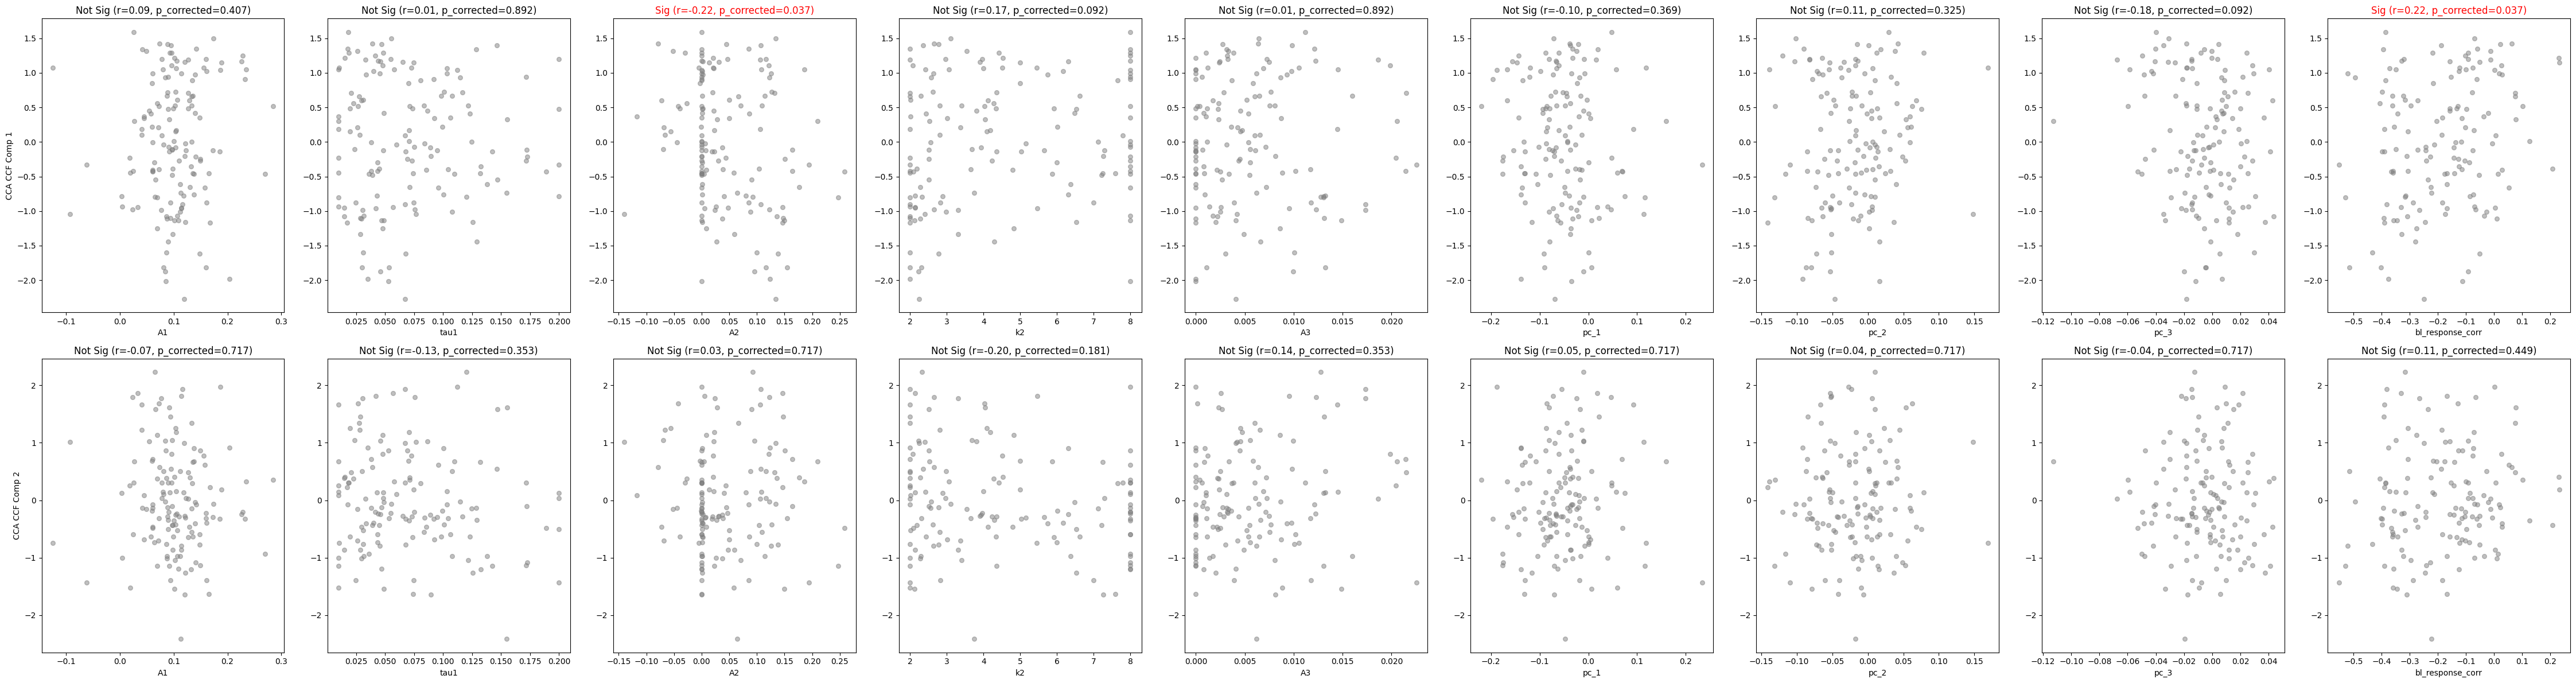

In [ ]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# --- create figure with 3 rows (CCA components) and one column per feature ---
fig, axes = plt.subplots(2, len(focus_features_cca), figsize=(5*len(focus_features_cca), 12))

for j in range(2):  # iterate over CCA components
    cca_ccf_values = cca_result_ccf[:, j].copy()
    all_p = []
    all_coef = []
    for i, feature in enumerate(focus_features_cca):
        ax = axes[j, i]
        feature_values = features_combined[feature].values[filter][~nan_ind_cca]

        # scatter plot
        ax.scatter(feature_values, cca_ccf_values, c='gray', alpha=0.5, s=30)
        ax.set_xlabel(feature)
        if i == 0:
            ax.set_ylabel(f'CCA CCF Comp {j+1}')

        # compute correlation
        corr_coef, p_value = pearsonr(feature_values, cca_ccf_values)
        all_p.append(p_value)
        all_coef.append(corr_coef)

    # adjust for multiple comparisons 
    reject, pvals_corrected, _, _ = multipletests(all_p, method='fdr_bh', alpha=0.05)
    for i, ax in enumerate(axes[j, :]):
        if reject[i]:
            ax.set_title(f'Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='red')
        else:
            ax.set_title(f'Not Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='black')



plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_beh_CCF_scatter_by_component.pdf'),
    bbox_inches='tight', dpi=300
)
plt.show()

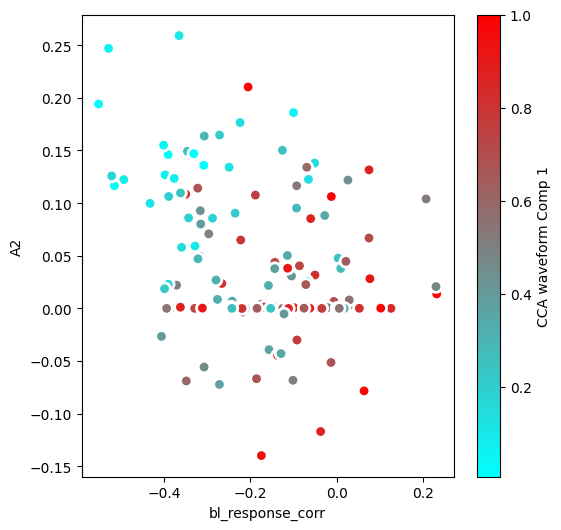

In [ ]:
fig = plt.figure(figsize=(6, 6))
x_val = 'bl_response_corr'
y_val = 'A2'
x = features_combined[x_val][filter][~nan_ind_cca]
# add a bit noise
# x = x + np.random.normal(0, 0.01, size=x.shape)
# y = np.log(-combinedf_features['post_slope']+0.00001)[~nan_ind_cca]
y = features_combined[y_val][filter][~nan_ind_cca]
color_code = cca_result_be[:, 0]
color_code = rankdata(color_code) / len(color_code)
sc = plt.scatter(x, y, c = color_code, cmap = custom_cmap, alpha = 1, edgecolor = 'white', s = 70, linewidths= 2)
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.colorbar(sc, label='CCA waveform Comp 1')
plt.savefig(os.path.join(target_folder, f'{y_val}_vs_{x_val}_cca_comp1.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(wf_folder, f'cca_behavioral_comp1_vs_postw_symmslope.svg'), dpi=300, bbox_inches='tight')

NameError: name 'cca_result_be' is not defined

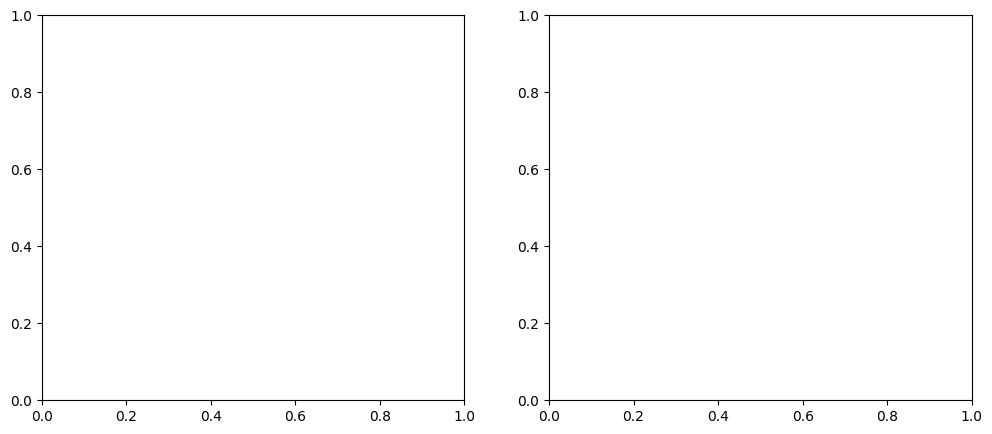

In [ ]:
# binned waveform by cca1 and 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
n_bins = 4
for i in range(2):
    ax = axes[i]
    cca_values = cca_result_be[:, i].copy()
    bins = np.quantile(cca_values, np.linspace(0, 1, n_bins+1))
    bins = np.linspace(bins[0], bins[-1], n_bins+1)  # ensure bins are evenly spaced
    bin_indices = np.digitize(cca_values, bins) - 1  # bin indices from 0 to n_bins-1
    for b in range(n_bins):
        idx = bin_indices == b
        if np.sum(idx) > 0:
            mean_waveform = np.nanmean(auto_corr_mat_denoised[~nan_ind_cca][idx], axis=0)
            ax.plot(x_vals, mean_waveform, label=f'Bin {b+1} (n={np.sum(idx)})', c = custom_cmap(b / (num_bins - 1)))
    ax.set_title(f'CCA Waveform Comp {i+1} Binned Waveforms')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Mean Waveform Value')
    ax.legend()
    ax.set_xlim(-0.2, 1.2)

In [ ]:
# bin C1 and C2 into CCA 1 and 2 bins
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
bin_num = 3
for comp in range(2):
    cca_values = cca_result_be[:, comp].copy()
    bins = np.quantile(cca_values, np.linspace(0, 1, bin_num+1))
    bins = np.linspace(bins[0], bins[-1], bin_num+1)  # ensure bins are evenly spaced
    bin_indices = np.digitize(cca_values, bins) - 1  # bin indices from 0 to bin_num-1
    for b in range(bin_num):
        idx = bin_indices == b
        if np.sum(idx) > 0:
            mean_C1 = np.nanmean(C1_mat[~nan_ind_cca][idx], axis=0)
            sem_C1 = np.nanstd(C1_mat[~nan_ind_cca][idx], axis=0) / np.sqrt(np.sum(idx))
            mean_C2 = np.nanmean(C2_mat[~nan_ind_cca][idx], axis=0)
            sem_C2 = np.nanstd(C2_mat[~nan_ind_cca][idx], axis=0) / np.sqrt(np.sum(idx))
            mean_C3 = np.nanmean(C3_mat[~nan_ind_cca][idx], axis=0)
            sem_C3 = np.nanstd(C3_mat[~nan_ind_cca][idx], axis=0) / np.sqrt(np.sum(idx))
            axes[0, comp].plot(mean_C1, label=f'Bin {b+1} C1 (n={np.sum(idx)})', c = custom_cmap(b / (bin_num - 1)))
            axes[0, comp].fill_between(np.arange(len(mean_C1)), mean_C1 - sem_C1, mean_C1 + sem_C1, color=custom_cmap(b / (bin_num - 1)), alpha=0.3)
            axes[1, comp].plot(mean_C2, label=f'Bin {b+1} C2 (n={np.sum(idx)})', c = custom_cmap(b / (bin_num - 1)))
            axes[1, comp].fill_between(np.arange(len(mean_C2)), mean_C2 - sem_C2, mean_C2 + sem_C2, color=custom_cmap(b / (bin_num - 1)), alpha=0.3)
            axes[2, comp].plot(mean_C3, label=f'Bin {b+1} C3 (n={np.sum(idx)})', c = custom_cmap(b / (bin_num - 1)))
            axes[2, comp].fill_between(np.arange(len(mean_C3)), mean_C3 - sem_C3, mean_C3 + sem_C3, color=custom_cmap(b / (bin_num - 1)), alpha=0.3)

            if comp == 0:
                axes[0, comp].set_ylabel('Mean C1') 
                axes[1, comp].set_ylabel('Mean C2')
                axes[2, comp].set_ylabel('Mean C3')

    axes[0, comp].set_title(f'CCA Comp {comp+1} Binned Waveforms')
    axes[-1, comp].set_xlabel('Time Points')
    axes[0, comp].legend()

# Shuffling

In [ ]:
# create a functions that takes in cca_be_mat and ccf_mat and performs the entire cca with bootstrap and returns the cca results with ci
# outputs: cca_result_be, cca_result_ccf, xw_low, xw_high, yw_low, yw_high, boot_xw, boot_yw, cca_x_weights, cca_y_weights
from collections import defaultdict
def perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05, return_all=False):
    # Fit original CCA
    cca = CCA(n_components=2)
    cca.fit(cca_be_mat, ccf_mat)
    xw = cca.x_weights_
    yw = cca.y_weights_

    cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

    cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)

    # Bin data into 3D voxels
    coords = ccf_mat
    n_bins_xyz = (3, 3, 4)
    bins = [
        np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
        for i in range(3)
    ]
    xbin = np.digitize(coords[:, 0], bins[0]) - 1
    ybin = np.digitize(coords[:, 1], bins[1]) - 1
    zbin = np.digitize(coords[:, 2], bins[2]) - 1

    voxel_map = defaultdict(list)
    for i in range(len(coords)):
        v = (xbin[i], ybin[i], zbin[i])
        voxel_map[v].append(i)

    valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]
    counts = np.array([len(voxel_map[v]) for v in valid_voxels])
    total_count = counts.sum()
    samples_per_voxel = np.maximum(1, np.floor((counts / total_count) * n_samples).astype(int))

    # Bootstrap loop
    rng = np.random.default_rng(4)
    boot_xw = np.zeros((n_boot, cca_be_mat.shape[1], 2))
    boot_yw = np.zeros((n_boot, 3, 2))

    for b in range(n_boot):
        indices = []
        for vox_idx, voxel in enumerate(valid_voxels):
            n_draw = voxel_map[voxel].__len__()
            picked = rng.choice(
                voxel_map[voxel],
                size=n_draw,
                replace=True
            )
            indices.extend(picked)
        indices = np.array(indices)
        Xb = cca_be_mat[indices]
        Yb = ccf_mat[indices]
        cca_b = CCA(n_components=2)
        cca_b.fit(Xb, Yb)
        boot_xw[b] = cca_b.x_weights_
        boot_yw[b] = cca_b.y_weights_
        # for comp in range(2):
        #     xw = cca_b.x_weights_[:, comp]
        #     yw = cca_b.y_weights_[:, comp]
        #     xw /= np.linalg.norm(xw)
        #     yw /= np.linalg.norm(yw)
        #     boot_xw[b, :, comp] = xw
        #     boot_yw[b, :, comp] = yw
        # xw = cca_b.x_weights_[:, 0]
        # yw = cca_b.y_weights_[:, 0]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 0] = xw
        # boot_yw[b, :, 0] = yw
        # # # second component (optional)
        # xw = cca_b.x_weights_[:, 1]
        # yw = cca_b.y_weights_[:, 1]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 1] = xw
        # boot_yw[b, :, 1] = yw
        # Xb_res = Xb - (Xb @ xw[:, 0][:, None]) * xw[:, 0][None, :]
        # Yb_res = Yb - (Yb @ yw[:, 0][:, None]) * yw[:, 0][None, :]
        # cca_b2 = CCA(n_components=1)
        # cca_b2.fit(Xb_res, Yb_res)
        # xw_2 = cca_b2.x_weights_[:, 0]
        # yw_2 = cca_b2.y_weights_[:, 0]
        # boot_xw[b, :, 1] = xw_2
        # boot_yw[b, :, 1] = yw_2
    # Sign alignment
    boot_yw_aligned = boot_yw.copy()
    boot_xw_aligned = boot_xw.copy()

    boot_yw_norm = (
        boot_yw_aligned /
        np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
    )

    for comp in range(2):
        ref = cca_vecs[:, comp]
        for b in range(n_boot):
            if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
                boot_yw_aligned[b, :, comp] *= -1
                boot_xw_aligned[b, :, comp] *= -1




    boot_yw = boot_yw_aligned
    boot_xw = boot_xw_aligned

    boot_yw = (
        boot_yw /
        np.linalg.norm(boot_yw, axis=1, keepdims=True)
    )

    # compute CI bounds
    xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
    xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)
    yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
    yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

    # save correlation of cca results
    corrs = np.corrcoef(cca_result_be.T, cca_result_ccf.T)
    corrs = np.diag(corrs[:2, 2:])

    # Compute angles 
    phi_boot = np.zeros((n_boot, 2))
    theta_boot = np.zeros((n_boot, 2))
    # mean vector
    v_mean = np.nanmean(boot_yw, axis=0)
    ang_mean_0 = np.arctan2(v_mean[1, 0], v_mean[0, 0])
    # ang_mean_1 = np.arctan2(v_mean[1, 1], v_mean[0, 1])
    # for comp 0
    comp = 0
    for b in range(n_boot):
        v = boot_yw[b, :, comp]
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi-ang_mean_0)
    # for comp 1
    comp = 1
    v_proj = np.zeros((n_boot, 3))
    for b in range(n_boot):
        # project v onto plane orthogonal to component 0
        v_proj[b, :], R = express_in_basis(boot_yw[b, :, comp], cca_vecs[:, 0])
        # convert projected 2D vector to angles
    # mean vector
    v_mean_1 = np.nanmean(v_proj, axis=0)
    ang_mean_1 = np.arctan2(v_mean_1[1], v_mean_1[0])
    for b in range(n_boot):
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj[b, :], off_set=np.pi - ang_mean_1)

    # compute angles for original CCA vectors
    phi_orig = np.zeros(2)
    theta_orig = np.zeros(2)
    # for comp 0
    comp = 0
    v0 = cca_vecs[:, comp]   # normalized
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=-0.5)
    # for comp 1
    comp = 1
    v1 = cca_vecs[:, comp]
    v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set=1)


    # variance for directions:
    cov_matrix_comp0 = np.cov((boot_yw[:, :, 0]).T)
    cov_matrix_comp1 = np.cov((boot_yw[:, :, 1]).T)
    # eigen decomposition
    eigvals_vec_0, eigvecs_vec_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_vec_0)
    principal_dir0_vec = eigvecs_vec_0[:, max_idx0]
    principal_var0_vec = eigvals_vec_0[max_idx0]

    eigvals_vec_1, eigvecs_vec_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_vec_1)
    principal_dir1_vec = eigvecs_vec_1[:, max_idx1]
    principal_var1_vec = eigvals_vec_1[max_idx1]

    # variance for angles:
    # calcuate covariance of phi and theta
    cov_matrix_comp0 = np.cov(theta_boot[:, 0], phi_boot[:, 0])
    cov_matrix_comp1 = np.cov(theta_boot[:, 1], phi_boot[:, 1])
    # eigen decomposition
    # For component 0
    eigvals_ang_0, eigvecs_ang_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_ang_0)
    principal_dir0_ang = eigvecs_ang_0[:, max_idx0]
    principal_var0_ang = eigvals_ang_0[max_idx0]

    # For component 1
    eigvals_ang_1, eigvecs_ang_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_ang_1)
    principal_dir1_ang = eigvecs_ang_1[:, max_idx1]
    principal_var1_ang = eigvals_ang_1[max_idx1]
    result = {'corrs': corrs,
                # 'cca_result_be': cca_result_be,
                # 'cca_result_ccf': cca_result_ccf,
                # 'xw_low': xw_low,
                # 'xw_high': xw_high,
                # 'yw_low': yw_low,
                # 'yw_high': yw_high,
                # 'boot_xw': boot_xw,
                # 'boot_yw': boot_yw,
                'cca_x_weights': cca.x_weights_,
                'cca_y_weights': cca.y_weights_,
                'cca_vecs': cca_vecs,
                # 'phi_boot': phi_boot,
                # 'theta_boot': theta_boot,
                'phi_orig': phi_orig,
                'theta_orig': theta_orig,
                # 'var_phi': var_phi,
                # 'var_theta': var_theta,
                'eigvals_vec_0': np.sort(eigvals_vec_0)[::-1],
                # 'eigvecs_vec_0': eigvecs_vec_0,
                'eigvals_vec_1': np.sort(eigvals_vec_1)[::-1], 
                # 'eigvecs_vec_1': eigvecs_vec_1,
                'eigvals_ang_0': np.sort(eigvals_ang_0)[::-1],
                # 'eigvecs_ang_0': eigvecs_ang_0,
                'eigvals_ang_1': np.sort(eigvals_ang_1)[::-1],
                # 'eigvecs_ang_1': eigvecs_ang_1,
                }
    if not return_all:
        return result
    else:
        result.update({
            'boot_xw': boot_xw,
            'boot_yw': boot_yw,
            'phi_boot': phi_boot,
            'theta_boot': theta_boot,
        })
        return result
        
        
def shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05):
    # shuffle the cca_be_mat
    shuffled_cca_be_mat = cca_be_mat.copy()
    np.random.shuffle(shuffled_cca_be_mat)
    # perform cca with bootstrap
    results = perform_cca_with_bootstrap(shuffled_cca_be_mat, ccf_mat, n_samples, n_boot, alpha, return_all=False)
    return results

In [ ]:
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['isi_violations'] < 0.5
cca_be_mat = features_combined[focus_features].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
# zscore
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
# ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
result_ori = perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05, return_all=True)
# result = shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=1000, n_boot=1000, alpha=0.05)

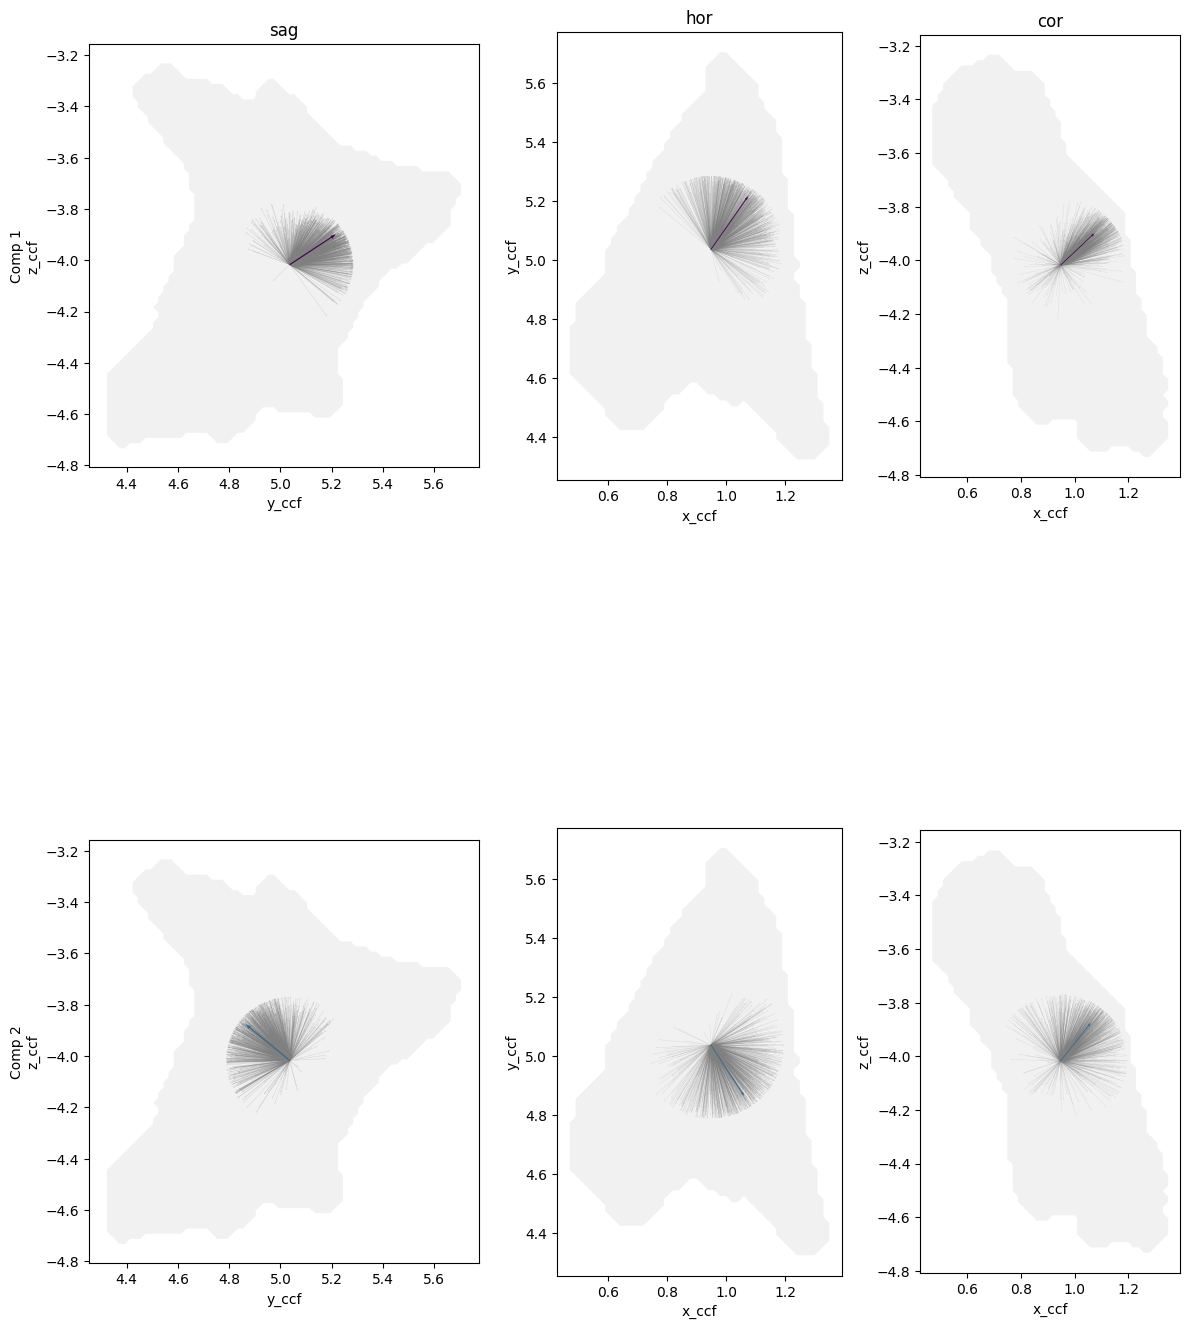

In [ ]:
# Plot
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = result_ori['boot_yw'][b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp]

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
from joblib import Parallel, delayed
parallel_results = Parallel(n_jobs=10)(
    delayed(shuffle_cca_with_bootstrap)(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05)
    for _ in range(500)
)

/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warn

In [ ]:
# make results into df
shuffle_eigvals_vec_0 = np.array([res['eigvals_vec_0'] for res in parallel_results])
shuffle_eigvals_vec_1 = np.array([res['eigvals_vec_1'] for res in parallel_results])
shuffle_eigvals_ang_0 = np.array([res['eigvals_ang_0'] for res in parallel_results])
shuffle_eigvals_ang_1 = np.array([res['eigvals_ang_1'] for res in parallel_results])
shuffle_corr_0 = np.array([res['corrs'][0] for res in parallel_results])
shuffle_corr_1 = np.array([res['corrs'][1] for res in parallel_results])
import pandas as pd
shuffle_results_df = pd.DataFrame({
    'eigvals_vec_0_1': shuffle_eigvals_vec_0[:, 0],
    'eigvals_vec_0_2': shuffle_eigvals_vec_0[:, 1],
    'eigvals_vec_1_1': shuffle_eigvals_vec_1[:, 0],
    'eigvals_vec_1_2': shuffle_eigvals_vec_1[:, 1],
    'eigvals_ang_0_1': shuffle_eigvals_ang_0[:, 0],
    'eigvals_ang_0_2': shuffle_eigvals_ang_0[:, 1],
    'eigvals_ang_1_1': shuffle_eigvals_ang_1[:, 0],
    'eigvals_ang_1_2': shuffle_eigvals_ang_1[:, 1],
    'corr_0': shuffle_corr_0,
    'corr_1': shuffle_corr_1
})


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
# Plot eigenvalue distributions for vector space
type = 'ang'
for comp in range(2):
    for eigen_int in range(2):
        ax = axes[comp, eigen_int]
        ax.hist(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'],
            bins=30, color='gray', alpha=0.7
        )
        ax.axvline(
            x=result_ori[f'eigvals_{type}_{comp}'][eigen_int],
            color='red', linestyle='--',
            label='Original CCA'
        )
        p_value = np.mean(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'] <=
            result_ori[f'eigvals_{type}_{comp}'][eigen_int]
        )
        ax.set_title(f'Comp {comp+1} - EV {eigen_int+1} (p={p_value:.3f})')
    eigen_sum = result_ori[f'eigvals_{type}_{comp}'].sum()
    eigen_sum_shuffle = shuffle_results_df[[f'eigvals_{type}_{comp}_1', f'eigvals_{type}_{comp}_2']].sum(axis=1)
    p_value = np.mean(eigen_sum_shuffle <= eigen_sum)
    axes[comp, 2].hist(
        eigen_sum_shuffle,
        bins=30, color='gray', alpha=0.7
    )
    axes[comp, 2].axvline(
        x=eigen_sum,
        color='red', linestyle='--',
        label='Original CCA'
    )
    axes[comp, 2].set_title(f'Comp {comp+1} - EV Sum (p={p_value:.3f})')
plt.suptitle(f'CCA Bootstrap Eigenvalues in Vector Space-type_{type}')
# plt.sca(axes[0, 0])
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_variance_by_eigenvalues_{type}.pdf'),
    bbox_inches='tight'
)

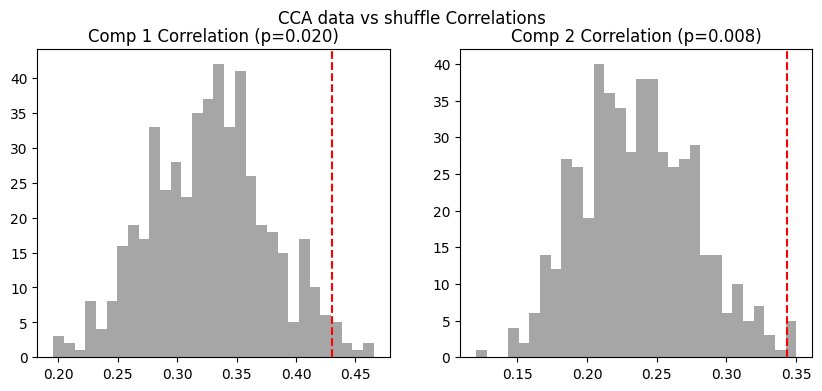

In [ ]:
# plot the same for corr
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for comp in range(2):
    ax = axes[comp]
    ax.hist(
        shuffle_results_df[f'corr_{comp}'],
        bins=30, color='gray', alpha=0.7
    )
    ax.axvline(
        x=result_ori['corrs'][comp],
        color='red', linestyle='--',
        label='Original CCA'
    )
    p_value = np.mean(
        shuffle_results_df[f'corr_{comp}'] >=
        result_ori['corrs'][comp]
    )
    ax.set_title(f'Comp {comp+1} Correlation (p={p_value:.3f})')
plt.suptitle(f'CCA data vs shuffle Correlations')
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_correlation.pdf'),
    bbox_inches='tight'
)

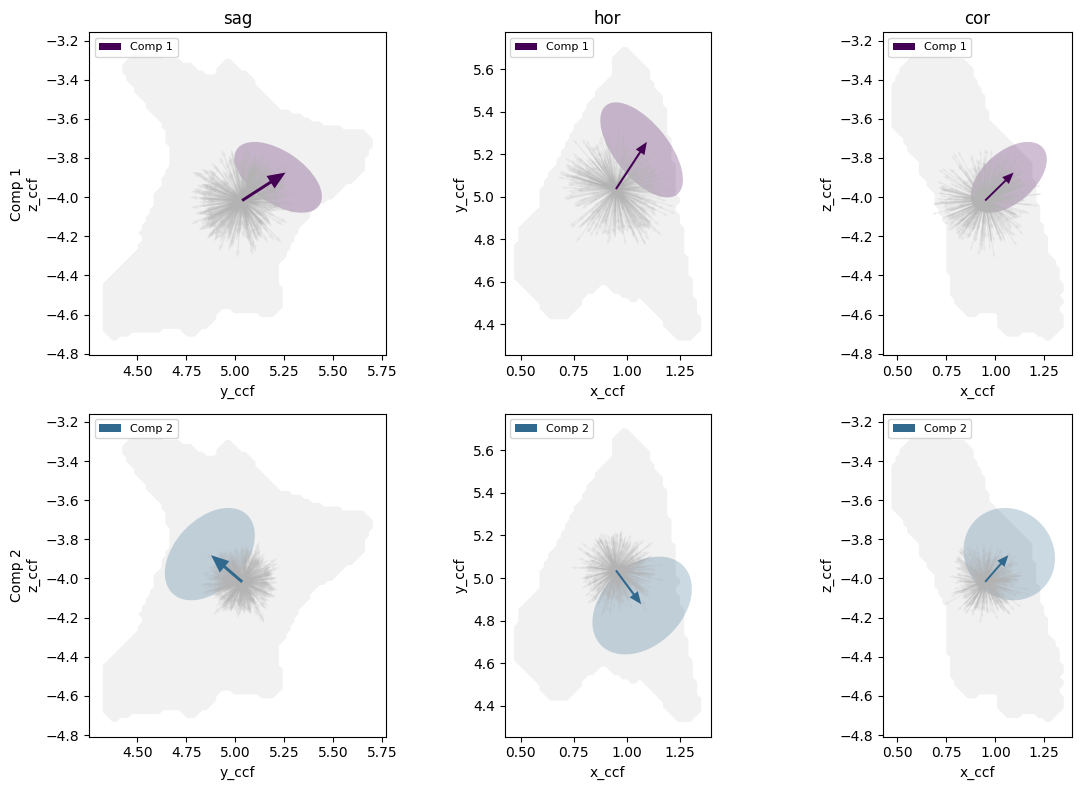

In [ ]:
# plot shuffled cca vectors in 2D planes with cones
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

boot_yw = result_ori['boot_yw']
boot_yw = boot_yw / np.linalg.norm(boot_yw, axis=1, keepdims=True)

n_boot = boot_yw.shape[0]

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
ci = 0.95
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # ----------------------------
        from scipy.stats import chi2
        # central 90% CI == 5% to 95%
        chi2_val = chi2.ppf(ci, df=2) # 2D chi-square quantile
        scale_ci = np.sqrt(chi2_val)

        boot_vecs = boot_yw_norm[:, :, comp]  # (n_boot, 3)
        # normalize each bootstrap vector (important if not already)
        boot_vecs = boot_vecs / np.linalg.norm(boot_vecs, axis=1, keepdims=True)

        # Mean vector (unit norm)
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # 2D projected direction (unit norm in 3D; 2D length varies)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        scale = 1/0.25  # your arrow scaling factor

        # --- Work in endpoint space (matches what you plot) ---
        endpts = np.column_stack([
            origin[ix] + vecs_2d[:, 0] / scale,
            origin[iy] + vecs_2d[:, 1] / scale,
        ])

        # Center ellipse at the mean endpoint
        end_mean = np.array([
            origin[ix] + mean_2d[0] / scale,
            origin[iy] + mean_2d[1] / scale,
        ])

        # Covariance of endpoints (NOT divided by n_boot)
        cov = np.cov(endpts.T)

        # Eigen-decomposition for ellipse axes
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        # Ellipse parameters for 90% CI
        width, height = 2 * scale_ci * np.sqrt(eigvals)  # factor 2 because width/height are full lengths
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

        ellipse = Ellipse(
            xy=end_mean,
            width=width, height=height, angle=angle,
            edgecolor=None,
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)



        # ----------------------------
        # All shuffle vectors (transparent)
        # ----------------------------
        for shu in parallel_results:
            shu_vec = shu['cca_y_weights'][:, comp]
            shu_vec /= np.linalg.norm(shu_vec)
            scale = (1/(shu['corrs'][comp]))*1/0.7
            ax.quiver(
                origin[ix], origin[iy],
                shu_vec[ix], shu_vec[iy],
                angles='xy', scale_units='xy', scale=scale,
                color=[0.7, 0.7, 0.7],
                alpha=0.2,
                width=0.005,
                linewidth=0.01
            )
        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        scale = (1/result_ori['corrs'][comp])*1/0.7  # scaling factor for arrow length
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.01,            # ⬅️ thicker arrow shaft (was 0.004)
            linewidth=1.5,         # ⬅️ slightly heavier outline
            headwidth=5,          # ⬅️ makes arrowhead wider
            headlength=6,         # ⬅️ makes arrowhead longer
            headaxislength=6,     # ⬅️ makes axis-aligned portion of head larger
            label=f'Comp {comp+1}'
        )


        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, f'CCA_CCF_components_bootstrap&shuffle_CI_{ci}_cones.pdf'),
    bbox_inches='tight'
)
plt.show()
